Import libraries

In [1]:
import os
import fitsio as ft
import numpy as np
import matplotlib.pyplot as plt
import logging 
from scipy.optimize import curve_fit, minimize
import scipy.special as sp
import sys
sys.path.append("/global/homes/a/arosado/photometry/")
from photometry import Catalogue, utils, setup_logging

#logger = logging.getLogger('DA02')
#setup_logging()

# Class test

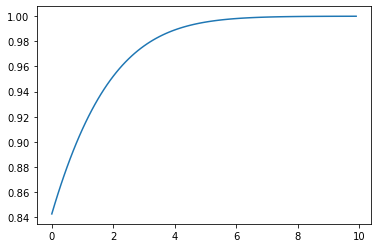

In [2]:
# We try an erf function to model the depth portion
x = np.arange(0,10,0.1)
d,e,f = [1,5,1]
plt.plot(x,d*sp.erf(x/e+f))

In [3]:
def get_legacysim_data(z_col='INPUT_HSC_MIZUKI_PHOTOZ_BEST', zmin=0.6,zmax=1.6,region='south'):
        test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'

        # legacysim data
        legacysim = ft.read(f'{test_dir}/legacysim_data_{region}.fits')
        z = legacysim[z_col]
        depth = legacysim['GALDEPTH_R']
        mask = z>zmin
        mask &= z<zmax
        mask &= depth > 0
        legacysim = legacysim[mask]
       
        return legacysim
    
def get_ELG_data(zmin=0.6,zmax=1.6,region='south'):
        test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
        base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'
    
        data_full = ft.read(f'{test_dir}/data_{region}.fits')
        data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format('ELG_LOPnotqso')))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        cat = data_clustering[ind1]
        z = cat['Z']
        depth = data_full['GALDEPTH_R'][ind2]
        
        mask = z>zmin
        mask &= z<zmax
        mask &= depth > 0
        cat = cat[mask]
        depth = depth[mask]
        cat.columns['GALDEPTH_R'] = depth
        
        return cat
    
class ELG_dndz:
    def __init__(self, zmin=0.6, zmax=1.6, bins=50,run='south'):
        self.region = run[0].upper()
        test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
        
        # legacysim data
        z_col = 'INPUT_HSC_MIZUKI_PHOTOZ_BEST'
        self.legacysim = get_legacysim_data(z_col=z_col,zmin=zmin,zmax=zmax,region=run)
        self.z = self.legacysim[z_col]
        self.depth = self.legacysim['GALDEPTH_R']
        self.weights = None

        # ELG data
        self.cat = get_ELG_data(zmin=zmin,zmax=zmax,region=run)
        self.z_cat = self.cat['Z']
        self.depth_cat = self.cat['GALDEPTH_R']
        self.weights_cat = self.cat['WEIGHT_COMP']

        # redshif bins
        self.bins = bins+1
        self.zbins = np.linspace(zmin, zmax, self.bins)
        self.bc = (self.zbins[:-1] + self.zbins[1:])/2.

        self.quantiles = np.quantile(self.depth, q=np.linspace(0., 1., 6))
        self.labels = ['{:.0f} < {} < {:.0f}'.format(low, 'depth_r', high) for low, high in zip(self.quantiles[:-1], self.quantiles[1:])]
        self.samples = np.clip(np.digitize(self.depth, self.quantiles) - 1, 0, len(self.quantiles) - 1)
        self.usamples = np.unique(self.samples)
        self.nsamples = len(self.usamples)-1  

        self.bin_data_dndz()
        self.new_weights = self.get_pred_weights()#*self.weights_cat
    
    def dndz_model(self,X, a, b, c, d, e, f, g):
        #[1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0]
        z_, depth_base = X
        depth_ = np.log10(depth_base)
        res = []
        for z, depth in zip(z_, depth_):
            if z < c:
                res.append((a + b*z) * (d*sp.erf(depth/e+f) + g))
            elif z >= c:
                res.append((a + b*c) * (d*sp.erf(depth/e+f) + g))
        res = np.array(res)
        return res

    def cost(self, params):
        # get chi2 using simulated data
        dndz_pred = self.dndz_model((self.z_h, self.depth_h), *params)
        c = np.sum(((self.dndz_h - dndz_pred)/(self.yerr))**2)
        return c
    
    def test(self):
        # minimize cost function using binned simulated data
        options = {'maxfev': 4*7*200, 'maxiter': 1000}
        return minimize(self.cost,[1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0], method='Powell', tol=1e-6, options=options) 
                           
    def bin_data_dndz(self):
        # function to bin simulated data into 5 depth bins, each depth bin with `self.bins` number of bins
        dndzw = np.histogram(self.z, bins=self.zbins, weights=self.weights)[0]
        dndz = np.histogram(self.z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, sample in enumerate(self.usamples):
            mask = self.samples == sample
            depth_sample = np.full_like(self.bc, self.depth[mask].mean())
            
            dndzw_sample = np.histogram(self.z[mask], bins=self.zbins, weights=self.weights[mask] if self.weights is not None else None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.

            if isample < self.nsamples:
                #print(f'max depth in bin {isample}: {self.depth[mask].max()}')
                z_list.append(self.bc)
                depth_list.append(depth_sample)
                dndz_list.append(dndz_norm)
                yerr_ = 1 / np.sqrt(dndzw_sample)
                yerr_list.append(yerr_)
            
        self.z_h = np.concatenate(z_list)
        self.depth_h = np.concatenate(depth_list)
        self.dndz_h = np.concatenate(dndz_list)
        self.yerr = np.concatenate(yerr_list)
    
    def get_pred_weights(self):
        # apply fit at catalog level using optimal parameters obtained from fitting binned simulated data
        self.res = self.test()
        self.params = self.res.x
        f = self.dndz_model((self.z_cat, self.depth_cat),*self.params)
        self.dndz_vals = f
        print(f'min(dndz - 1): {f.min()}, max(dndz - 1): {f.max()}')
        w = 1/(f+1)
        return w
    
    def get_chi2(self):
        #
        N,n = len(self.dndz_h), len(self.params)
        print(f'number of data points: {N}')
        print (f'number of free parameters: {n}')
        chi2 = self.res.fun / (N-n)
        print(f'reduced $\chi^2$: {chi2}')
        return chi2
        
    # below is code for visualization
    def plot_dndz(self, z, depth, weights=None, legend=False, ls='-'):
        ax = plt.gca()
        fig = plt.gcf()
        #fig.set_size_inches(7, 5)
        #ax.plot([], [], linestyle=ls, color='k', label='using pred weights')
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        labels = ['{:.0f} < {} < {:.0f}'.format(low, 'depth_r', high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        usamples = np.unique(samples)
        nsamples = len(usamples)-1  
        
        dndzw = np.histogram(z, bins=self.zbins, weights=weights)[0]
        dndz = np.histogram(z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, (sample, label) in enumerate(zip(usamples, labels)):
            mask = samples == sample
            depth_sample = np.full_like(self.bc, depth[mask].mean())
            dndzw_sample = np.histogram(z[mask], bins=self.zbins, weights=weights[mask] if weights is not None else None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.
            
            if isample < nsamples:
                if legend:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls, label=label)
                else:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls)
            
        
        #ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso'))
        if legend:
            ax.legend(loc=4, ncol=2)

## South

In [4]:
plot_dir = 'plots_fits'

min(dndz - 1): -0.5888101148780751, max(dndz - 1): 3.835820911047162
226.88697651814672
[ -0.77948942   0.94212811   0.83553054 -18.41448467  -0.66934513
   2.76041267 -15.32798643]


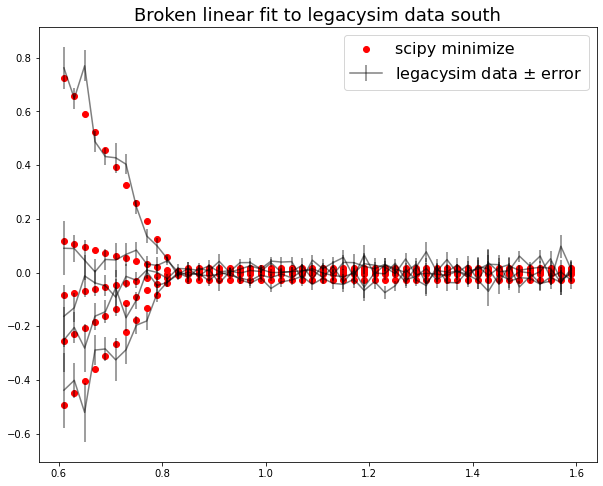

CPU times: user 6.4 s, sys: 1.43 s, total: 7.84 s
Wall time: 7.83 s


In [5]:
%%time
# Here we look at the effect of using yerr when fitting 

fig = plt.figure(figsize=(10,8))

run = 'south'
test = ELG_dndz(run=run)
print(test.res.fun)
#test.get_chi2()
params = test.params
print(params)
dndz = test.dndz_model((test.z_h, test.depth_h),*params)
plt.scatter(test.z_h, dndz, color='red', label='scipy minimize')

bins=test.bins-1
kw= dict(color='k', alpha=0.5)
plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
for ite in range(10):
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.errorbar(test.z_h[i:j], test.dndz_h[i:j], yerr=test.yerr[i:j], **kw)
    #plt.plot(test.z_h[i:j], (test.dndz_h[i:j]+1)/(dndz_err+1), yerr=test.yerr[i:j], **kw)
plt.legend(fontsize=16)
plt.title(f'Broken linear fit to legacysim data {run}', fontsize=18)
#plt.savefig(f'{plot_dir}/fit_legacysim_data_{run}.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()
#print(test.pred_weights.min(), test.pred_weights.max())

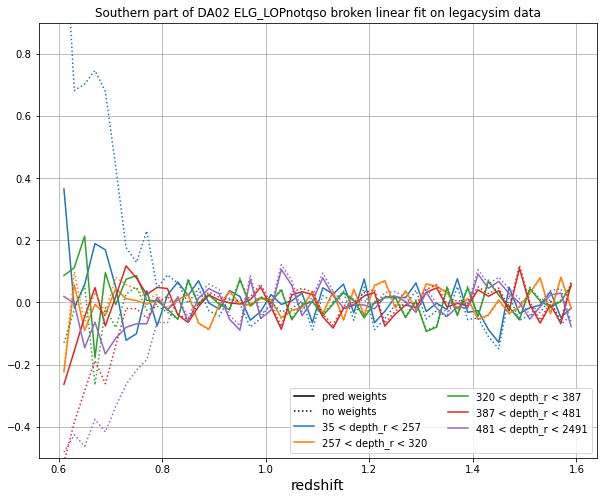

In [6]:
# Here we see effect of using dndz model with optimal parameters obtained from legacysim data
# on real ELG data (not legacysim/obiwan data) and using the result to get the predicted weights
#test = ELG_dndz(run='south')
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
#fig = plt.gcf()
#fig.set_size_inches(7, 5)
ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso')+' broken linear fit on legacysim data')#, fontsize=18)

ax.plot([], [], linestyle='-', color='k', label='pred weights')
ax.plot([], [], linestyle=':', color='k', label='no weights')

test.plot_dndz(test.z_cat, test.depth_cat, weights=test.new_weights*test.weights_cat, ls='-', legend=True)
plt.xlabel('redshift', fontsize=14)
plt.ylim(-0.5,0.9)
test.plot_dndz(test.z_cat, test.depth_cat, weights=test.weights_cat, ls=':')
ax.grid(True)
#plt.savefig(f'{plot_dir}/ELG_data_{run}.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

In [7]:
wmin, wmax = 0.5, 2.0 # min and max weight
print(f'total: {test.new_weights.size}')
print(f'weight less than {wmin}: {test.new_weights[test.new_weights < wmin].size}')
print(f'{test.new_weights[test.new_weights < wmin].size/test.new_weights.size*100:.3f}%')
print(f'weight greater than {wmax}: {test.new_weights[test.new_weights > wmax].size}')
print(f'{test.new_weights[test.new_weights > wmax].size/test.new_weights.size*100:.3f}%')

total: 126451
weight less than 0.5: 161
0.127%
weight greater than 2.0: 2
0.002%


In [8]:
dmin, dmax = -1.0, 1.0 # min and max [dndz - 1]
print(f'total: {test.dndz_vals.size}')
print(f'[dndz - 1] less than {dmin}: {test.dndz_vals[test.dndz_vals < dmin].size}')
print(f'{test.dndz_vals[test.dndz_vals < dmin].size/test.dndz_vals.size*100:.3f}%')
print(f'[dndz - 1] greater than {dmax}: {test.dndz_vals[test.dndz_vals > dmax].size}')
print(f'{test.dndz_vals[test.dndz_vals > dmax].size/test.dndz_vals.size*100:.3f}%')

total: 126451
[dndz - 1] less than -1.0: 0
0.000%
[dndz - 1] greater than 1.0: 161
0.127%


[ -0.77948942   0.94212811   0.83553054 -18.41448467  -0.66934513
   2.76041267 -15.32798643]
[1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2
 3.3 3.4]


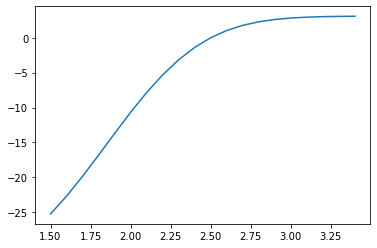

In [9]:
# function used to model depth dependence portion
a,b,c,d,e,f,g = test.params
print(test.params)
depth = np.arange(1.5,3.5,0.1)
print(depth)
fun = (d*sp.erf(depth/e+f) + g) 
plt.plot(depth, fun)
plt.show()

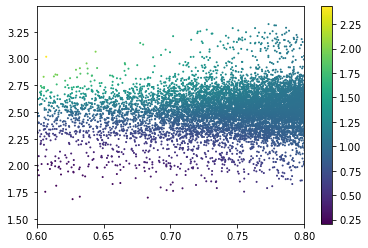

In [10]:
# Here we see how weights increase with increasing depth
#fig = plt.figure(figsize=(10,8))
sc = plt.scatter(test.z_cat,np.log10(test.depth_cat),c=test.new_weights, s=1)
plt.xlim(0.6,0.8)
plt.colorbar(sc)
plt.show()

## North

min(dndz - 1): -0.4451615825744787, max(dndz - 1): 2.5103146890937666
264.2844153815325
[ -0.96615876   1.18454155   0.82466143 -18.60946888  -0.97549129
   1.2729077  -15.28964207]


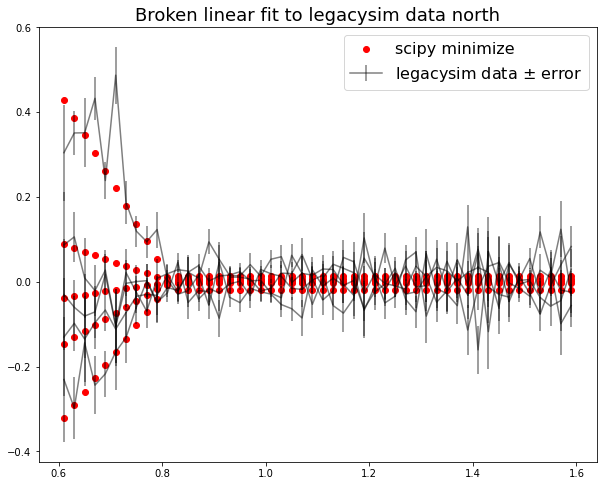

CPU times: user 5.6 s, sys: 691 ms, total: 6.29 s
Wall time: 6.29 s


In [11]:
%%time
# Here we look at the effect of using yerr when fitting 

fig = plt.figure(figsize=(10,8))

run = 'north'
test = ELG_dndz(run=run)
print(test.res.fun)
#test.get_chi2()
params = test.params
print(params)
dndz = test.dndz_model((test.z_h, test.depth_h),*params)
plt.scatter(test.z_h, dndz, color='red', label='scipy minimize')

bins=test.bins-1
kw= dict(color='k', alpha=0.5)
plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
for ite in range(10):
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.errorbar(test.z_h[i:j], test.dndz_h[i:j], yerr=test.yerr[i:j], **kw)
    #plt.plot(test.z_h[i:j], (test.dndz_h[i:j]+1)/(dndz_err+1), yerr=test.yerr[i:j], **kw)
plt.legend(fontsize=16)
plt.title(f'Broken linear fit to legacysim data {run}', fontsize=18)
#plt.savefig(f'{plot_dir}/fit_legacysim_data_{run}.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()
#print(test.pred_weights.min(), test.pred_weights.max())

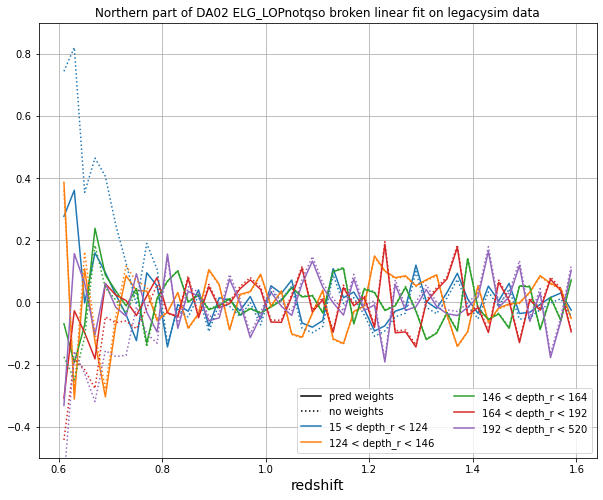

In [12]:
# Here we see effect of using dndz model with optimal parameters obtained from legacysim data
# on real ELG data (not legacysim/obiwan data) and using the result to get the predicted weights
#test = ELG_dndz(run='south')
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
#fig = plt.gcf()
#fig.set_size_inches(7, 5)
ax.set_title('Northern part of DA02 {}'.format('ELG_LOPnotqso')+' broken linear fit on legacysim data')#, fontsize=18)

ax.plot([], [], linestyle='-', color='k', label='pred weights')
ax.plot([], [], linestyle=':', color='k', label='no weights')

test.plot_dndz(test.z_cat, test.depth_cat, weights=test.new_weights*test.weights_cat, ls='-', legend=True)
plt.xlabel('redshift', fontsize=14)
plt.ylim(-0.5,0.9)
test.plot_dndz(test.z_cat, test.depth_cat, weights=test.weights_cat, ls=':')
ax.grid(True)
#plt.savefig(f'{plot_dir}/ELG_data_{run}.png', bbox_inches='tight', pad_inches=0.1, dpi=200, facecolor='white')
plt.show()

In [13]:
wmin, wmax = 0.5, 2.0 # min and max weight
print(f'total: {test.new_weights.size}')
print(f'weight less than {wmin}: {test.new_weights[test.new_weights < wmin].size}')
print(f'{test.new_weights[test.new_weights < wmin].size/test.new_weights.size*100:.3f}%')
print(f'weight greater than {wmax}: {test.new_weights[test.new_weights > wmax].size}')
print(f'{test.new_weights[test.new_weights > wmax].size/test.new_weights.size*100:.3f}%')

total: 47865
weight less than 0.5: 13
0.027%
weight greater than 2.0: 0
0.000%


In [14]:
dmin, dmax = -1.0, 1.0 # min and max [dndz - 1]
print(f'total: {test.dndz_vals.size}')
print(f'[dndz - 1] less than {dmin}: {test.dndz_vals[test.dndz_vals < dmin].size}')
print(f'{test.dndz_vals[test.dndz_vals < dmin].size/test.dndz_vals.size*100:.3f}%')
print(f'[dndz - 1] greater than {dmax}: {test.dndz_vals[test.dndz_vals > dmax].size}')
print(f'{test.dndz_vals[test.dndz_vals > dmax].size/test.dndz_vals.size*100:.3f}%')

total: 47865
[dndz - 1] less than -1.0: 0
0.000%
[dndz - 1] greater than 1.0: 13
0.027%


[ -0.96615876   1.18454155   0.82466143 -18.60946888  -0.97549129
   1.2729077  -15.28964207]
[1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2
 3.3 3.4]


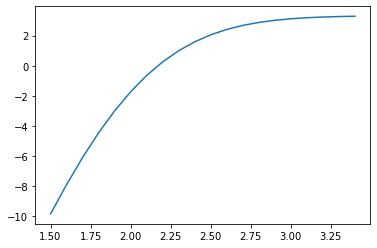

In [15]:
# function used to model depth dependence portion
a,b,c,d,e,f,g = test.params
print(test.params)
depth = np.arange(1.5,3.5,0.1)
print(depth)
fun = (d*sp.erf(depth/e+f) + g) 
plt.plot(depth, fun)
plt.show()

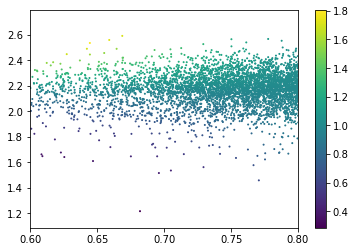

In [16]:
# Here we see how weights increase with increasing depth
#fig = plt.figure(figsize=(10,8))
sc = plt.scatter(test.z_cat,np.log10(test.depth_cat),c=test.new_weights, s=1)
plt.xlim(0.6,0.8)
plt.colorbar(sc)
plt.show()

# Class Old

In [2]:
class ELG_dndz_old:
    def __init__(self, catalogue, zmin=0.6, zmax=1.5, bins=50, data='legacysim', fit='exponential'):
            if data=='legacysim':
                self.cat = catalogue
                depth_mask = self.cat['GALDEPTH_R'] < 1500
                #print(f'{self.cat['GALDEPTH_R'].size - depth_mask.sum()}')
                self.z = self.cat['INPUT_HSC_MIZUKI_PHOTOZ_BEST'][depth_mask]
                self.weights = None#np.full(len(self.cat),1)
                self.depth = self.cat['GALDEPTH_R'][depth_mask]
    
            elif data=='catalogue':
                base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'
                data_full = catalogue
                data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format('ELG_LOPnotqso')))
                ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
                self.cat = data_clustering[ind1]
                self.z = self.cat['Z']
                self.weights = self.cat['WEIGHT_COMP']
                self.depth = data_full['GALDEPTH_R'][ind2]
            else:
                print('data must be legacysim data or catalogue data')
            #mask = self.z>zmin
            #mask &= self.z<zmax
            #self.cat = self.cat[mask]
            #self.z = self.z[mask]
            
            self.bins = bins+1
            self.zbins = np.linspace(zmin, zmax, self.bins)
            self.bc = (self.zbins[:-1] + self.zbins[1:])/2.
            
            self.quantiles = np.quantile(self.depth, q=np.linspace(0., 1., 6))
            self.labels = ['{:.0f} < {} < {:.0f}'.format(low, 'depth_r', high) for low, high in zip(self.quantiles[:-1], self.quantiles[1:])]
            self.samples = np.clip(np.digitize(self.depth, self.quantiles) - 1, 0, len(self.quantiles) - 1)
            self.usamples = np.unique(self.samples)
            self.nsamples = len(self.usamples)-1  
            
            self.fit = fit
            
            if data=='legacysim':
                self.new_weights = self.get_pred_weights()#*self.weights
            elif data=='catalogue':
                self.new_weights = self.get_pred_weights() * self.weights
                
    
    def predict_dndz_exp_old(self,X, a, b, c, d, e, f, g):
        z, depth = X
        return  (b * np.exp(-a*z) + c) * (d*depth + e*depth**2 + f*depth**3 + g)
    
    def predict_dndz_exp_test_old(self,X, a, b, c, d, e, f, g):
        z, depth = X                 
        return  (b * np.exp(-a*z+c)+1) * (d*depth + e*depth**2 + f*depth**3 + g)
    
    def predict_dndz_exp(self,X, a, b, c, d, e, f, g):
        z_, depth_ = X
        res = []
        for z, depth in zip(z_, depth_):
            if z < c:
                res.append((a + b*z) * (d*depth + e*depth**2 + f*depth**3 + g))
            elif z >= c:
                res.append((a + b*c) * (d*depth + e*depth**2 + f*depth**3 + g))
        res = np.array(res)
        #res[res<=-1] = -0.9
        return res #np.clip(res, -0.9,2)
    
    def predict_dndz_pol(self,X, a, b, c, d, e, f, g, h):
        z, depth = X
        return (a*z + b*z**2 + c*z**3 + d) * (e*depth + f*depth**2 + g*depth**3 + h)
        
    def fit_dndz(self, include_yerr=True):
        dndzw = np.histogram(self.z, bins=self.zbins, weights=self.weights)[0]
        dndz = np.histogram(self.z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, sample in enumerate(self.usamples):
            mask = self.samples == sample
            depth_sample = np.full_like(self.bc, self.depth[mask].mean())
            dndzw_sample = np.histogram(self.z[mask], bins=self.zbins, weights=self.weights[mask] if self.weights is not None else None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.

            if isample < self.nsamples:
                #print(f'max depth in bin {isample}: {self.depth[mask].max()}')
                z_list.append(self.bc)
                depth_list.append(depth_sample)
                dndz_list.append(dndz_norm)
                yerr_ = 1 / np.sqrt(dndzw_sample)
                yerr_list.append(yerr_)
            
        self.z_h = np.concatenate(z_list)
        self.depth_h = np.concatenate(depth_list)
        self.dndz_h = np.concatenate(dndz_list)
        self.yerr = np.concatenate(yerr_list)
        if include_yerr:
            if self.fit=='exponential':
                res = curve_fit(self.predict_dndz_exp, (self.z_h,self.depth_h), self.dndz_h, sigma=self.yerr, full_output=True)#, absolute_sigma=True)
            elif self.fit=='polynomial':
                res = curve_fit(self.predict_dndz_pol, (self.z_h,self.depth_h), self.dndz_h, sigma=self.yerr, full_output=True)#, absolute_sigma=True)
            else:
                print('model used to fit must be exponential or polynomial')
        else: 
            if self.fit=='exponential':
                res = curve_fit(self.predict_dndz_exp, (self.z_h,self.depth_h), self.dndz_h, full_output=True)
            elif self.fit=='polynomial':
                res = curve_fit(self.predict_dndz_pol, (self.z_h,self.depth_h), self.dndz_h, full_output=True)
            else:
                print('model used to fit must be exponential or polynomial')
        params = res[0]
        return res #params
    
    def get_pred_weights(self):
        # apply fit at catalog level using optimal parameters obtained from fitting binned data
        params = self.fit_dndz()[0]
        if self.fit=='exponential':
            f = self.predict_dndz_exp((self.z, self.depth),*params)
        elif self.fit=='polynomial':
            f = self.predict_dndz_pol((self.z, self.depth),*params)
        else:
            print('model used to fit must be exponential or polynomial')
        print(f.min(),f.max())
        #f = np.clip(f,-0.9,12)
        #f[f < 0] = 0 #abs(f[f < 0]) # change negatives to ? 
        self.f = f
        w = 1/(f+1)
        #w[w<0.5] = 0.5#1.
        return w#np.clip(w,0.5,2.)
    
    def get_chi2(self):
        res = self.fit_dndz()
        N,n = len (res[2]['fvec']), len(res[0])
        print(f'number of data points: {N}')
        print (f'number of free parameters: {n}')
        chi2 = (((res[2]['fvec'])/(self.yerr))**2).sum() #/ (N-n)
        print(f'reduced $\chi^2$: {chi2}')
        return chi2
        
    # below is code for visualization
    def plot_dndz_new_weights(self,legend=False, ls='-'):
        ax = plt.gca()
        fig = plt.gcf()
        #fig.set_size_inches(7, 5)
        #ax.plot([], [], linestyle=ls, color='k', label='using pred weights')
        
        dndzw = np.histogram(self.z, bins=self.zbins, weights=self.new_weights)[0]
        dndz = np.histogram(self.z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, (sample, label) in enumerate(zip(self.usamples, self.labels)):
            mask = self.samples == sample
            depth_sample = np.full_like(self.bc, self.depth[mask].mean())
            dndzw_sample = np.histogram(self.z[mask], bins=self.zbins, weights=self.new_weights[mask] if self.new_weights is not None else None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.
            
            if isample < self.nsamples:
                if legend:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls, label=label)
                else:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls)
            
        
        #ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso'))
        if legend:
            ax.legend(loc=4, ncol=2)
        
    def plot_dndz_no_pred_weights(self, legend=False, ls='-'):
        ax = plt.gca()
        fig = plt.gcf()
        #fig.set_size_inches(7, 5)
        #ax.plot([], [], linestyle=ls, color='k', label='no pred weights')
        
        dndzw = np.histogram(self.z, bins=self.zbins, weights=None)[0]
        dndz = np.histogram(self.z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, (sample, label) in enumerate(zip(self.usamples, self.labels)):
            mask = self.samples == sample
            depth_sample = np.full_like(self.bc, self.depth[mask].mean())
            dndzw_sample = np.histogram(self.z[mask], bins=self.zbins, weights=None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.
            
            if isample < self.nsamples:
                if legend:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls, label=label)
                else:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls)
            
        
        #ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso'))
        if legend:
            ax.legend(loc=4, ncol=2)
    

# Class

In [ ]:
class ELG_dndz:
    def __init__(self, catalogue, zmin=0.6, zmax=1.6, bins=50, data='legacysim', fit='exponential'):
            if data=='legacysim':
                self.cat = catalogue
                self.z = self.cat['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
                self.weights = None#np.full(len(self.cat),1)
                self.depth = self.cat['GALDEPTH_R']
    
            elif data=='catalogue':
                base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'
                data_full = catalogue
                data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format('ELG_LOPnotqso')))
                ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
                self.cat = data_clustering[ind1]
                self.z = self.cat['Z']
                self.weights = self.cat['WEIGHT_COMP']
                self.depth = data_full['GALDEPTH_R'][ind2]
            else:
                print('data must be legacysim data or catalogue data')
            mask = self.z>zmin
            mask &= self.z<zmax
            mask &= self.depth > 0
            self.cat = self.cat[mask]
            self.z = self.z[mask]
            self.depth = self.depth[mask]
            if data=='catalogue':
                self.weights = self.weights[mask]
            
            self.bins = bins+1
            self.zbins = np.linspace(zmin, zmax, self.bins)
            self.bc = (self.zbins[:-1] + self.zbins[1:])/2.
            
            self.quantiles = np.quantile(self.depth, q=np.linspace(0., 1., 6))
            self.labels = ['{:.0f} < {} < {:.0f}'.format(low, 'depth_r', high) for low, high in zip(self.quantiles[:-1], self.quantiles[1:])]
            self.samples = np.clip(np.digitize(self.depth, self.quantiles) - 1, 0, len(self.quantiles) - 1)
            self.usamples = np.unique(self.samples)
            self.nsamples = len(self.usamples)-1  
            
            self.fit = fit
            self.bin_data_dndz()
            #if data=='legacysim':
            self.new_weights = self.get_pred_weights()#*self.weights
            #elif data=='catalogue':
            #    self.new_weights = self.get_pred_weights() * self.weights
    
    def predict_dndz_old(self,X, a, b, c, d, e, f, g):
        #[1.0, 1.0, 0.8, -3.0, 0.0, 0.0, 6.0]
        z_, depth_base = X
        depth_ = np.log10(depth_base)
        res = []
        for z, depth in zip(z_, depth_):
            if z < c:
                res.append((a + b*z) * (d*depth + e*depth**2 + f*depth**3 + g))
            elif z >= c:
                res.append((a + b*c) * (d*depth + e*depth**2 + f*depth**3 + g))
        res = np.array(res)
        return res
    
    def predict_dndz_test1(self,X, a, b, c, d, e):
        #[1.0, 1.0, 0.8, -1.0, 0.0]
        z_, depth_base = X
        depth_ = np.log10(depth_base)
        res = []
        for z, depth in zip(z_, depth_):
            if z < c:
                res.append((a + b*z) * (d*depth + e))
            elif z >= c:
                res.append((a + b*c) * (d*depth + e))
        res = np.array(res)
        return res
    
    def predict_dndz_test(self,X, a, b, c, d, e, f):
        # [1.0, 1.0, 0.8, -1.0, 0.0, 0.0]
        z_, depth_base = X
        depth_ = np.log10(depth_base)
        res = []
        for z, depth in zip(z_, depth_):
            if z < c:
                res.append((a + b*z) * (d*depth +  e*depth**2 + f))
            elif z >= c:
                res.append((a + b*c) * (d*depth +  e*depth**2 + f))
        res = np.array(res)
        return res
    
    def predict_dndz(self,X, a, b, c, d, e, f, g):
        #[1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0]
        z_, depth_base = X
        depth_ = np.log10(depth_base)
        res = []
        for z, depth in zip(z_, depth_):
            if z < c:
                res.append((a + b*z) * (d*sp.erf(depth/e+f) + g))
            elif z >= c:
                res.append((a + b*c) * (d*sp.erf(depth/e+f) + g))
        res = np.array(res)
        return res


    def cost(self, params):
        dndz_pred = self.predict_dndz((self.z_h, self.depth_h), *params)
        penalty = 0 
        #if np.any(dndz_pred < -0.9): # notice that this penalty is not doing anything to help the fit
        #    penalty += 1000
        #depth_max = [2500,]
        #dndz_pred_max = self.predict_dndz((self.z_h, depth_max), *params)
        #if np.any(dndz_pred_max < -0.9):
        #    penalty += 1000
        c = np.sum(((self.dndz_h - dndz_pred)/(self.yerr))**2) + penalty
        #print(c)
        #print(params)
        return c
                           
    def bin_data_dndz(self):
        dndzw = np.histogram(self.z, bins=self.zbins, weights=self.weights)[0]
        dndz = np.histogram(self.z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, sample in enumerate(self.usamples):
            mask = self.samples == sample
            depth_sample = np.full_like(self.bc, self.depth[mask].mean()) # comment this out for test
            # added continuous depth as binned data
            #depth_sample_bin = np.linspace(self.depth[mask].min(), self.depth[mask].max(), self.bins)
            #depth_sample = (depth_sample_bin[:-1] + depth_sample_bin[1:])/2.
            
            dndzw_sample = np.histogram(self.z[mask], bins=self.zbins, weights=self.weights[mask] if self.weights is not None else None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.

            if isample < self.nsamples:
                #print(f'max depth in bin {isample}: {self.depth[mask].max()}')
                z_list.append(self.bc)
                depth_list.append(depth_sample)
                dndz_list.append(dndz_norm)
                yerr_ = 1 / np.sqrt(dndzw_sample)
                yerr_list.append(yerr_)
            
        self.z_h = np.concatenate(z_list)
        self.depth_h = np.concatenate(depth_list)
        self.dndz_h = np.concatenate(dndz_list)
        self.yerr = np.concatenate(yerr_list)

    def test(self):
        options = {'maxfev': 4*7*200, 'maxiter': 1000}
        #[-1.0e-06, 1.0e-06, 0.8, 1.0e+04, -10.0, 0.01, -1.0e+06], [1.0, 1.0, 0.8, -3.0, 0.0, 0.0, 6.0]
        return minimize(self.cost,[1.0, 1.0, 0.8, 1.0, 1.0, 0.0, 1.0], method='Powell', tol=1e-6, options=options) #[-2.0e-06, 2.0e-06, 8.0e-01, 3.0e+04, -7.0e+01, 4.0e-02, -5.0e+06], method='Powell', tol=1e-6)# 
    
    def get_pred_weights(self):
        # apply fit at catalog level using optimal parameters obtained from fitting binned data
        self.res = self.test()
        self.params = self.res.x
        
        #d = self.depth.copy()
        #d[self.depth==0.0] = 1e-12
        
        f = self.predict_dndz((self.z, self.depth),*self.params)
        self.dndz_vals = f
        print(f.min(),f.max())
        #f = np.clip(f,-0.9,12)
        #f[f < 0] = 0 #abs(f[f < 0]) # change negatives to ? 
        #self.f = f
        w = 1/(f+1)
        #w[w<0.5] = 0.5#1.
        return w #np.clip(w,0.5,2.)
    
    def get_chi2(self):
        #
        N,n = len(self.dndz_h), len(self.params)
        print(f'number of data points: {N}')
        print (f'number of free parameters: {n}')
        chi2 = self.res.fun / (N-n)
        print(f'reduced $\chi^2$: {chi2}')
        return chi2
        
    # below is code for visualization
    def plot_dndz_new_weights(self,legend=False, ls='-'):
        ax = plt.gca()
        fig = plt.gcf()
        #fig.set_size_inches(7, 5)
        #ax.plot([], [], linestyle=ls, color='k', label='using pred weights')
        
        dndzw = np.histogram(self.z, bins=self.zbins, weights=self.new_weights)[0]
        dndz = np.histogram(self.z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, (sample, label) in enumerate(zip(self.usamples, self.labels)):
            mask = self.samples == sample
            depth_sample = np.full_like(self.bc, self.depth[mask].mean())
            dndzw_sample = np.histogram(self.z[mask], bins=self.zbins, weights=self.new_weights[mask] if self.new_weights is not None else None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.
            
            if isample < self.nsamples:
                if legend:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls, label=label)
                else:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls)
            
        
        #ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso'))
        if legend:
            ax.legend(loc=4, ncol=2)
        
    def plot_dndz_no_pred_weights(self, legend=False, ls='-'):
        ax = plt.gca()
        fig = plt.gcf()
        #fig.set_size_inches(7, 5)
        #ax.plot([], [], linestyle=ls, color='k', label='no pred weights')
        
        dndzw = np.histogram(self.z, bins=self.zbins, weights=None)[0]
        dndz = np.histogram(self.z, bins=self.zbins)[0]
        
        z_list = []
        depth_list = []
        dndz_list = []
        yerr_list = []

        for isample, (sample, label) in enumerate(zip(self.usamples, self.labels)):
            mask = self.samples == sample
            depth_sample = np.full_like(self.bc, self.depth[mask].mean())
            dndzw_sample = np.histogram(self.z[mask], bins=self.zbins, weights=None)[0]
            ratio = dndzw_sample.sum()/dndzw.sum()
            dndz_norm =  1./ratio*dndzw_sample/dndzw - 1.
            
            if isample < self.nsamples:
                if legend:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls, label=label)
                else:
                    ax.plot(self.bc, dndz_norm, color='C{:d}'.format(isample), ls=ls)
            
        
        #ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso'))
        if legend:
            ax.legend(loc=4, ncol=2)
    

# code 

In [3]:
plot_dir = 'plots_fits'

run = 'south'
region = run[0].upper()
base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'

test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
legacysim_data, h = ft.read(f'{test_dir}/legacysim_data_{run}.fits', header=True)
data = ft.read(f'{test_dir}/data_{run}.fits')

No penalty: 
fev[min,max] = -410.0222127138587, 12.790710302845246

Penalty using binned data: 
fev[min,max] = -409.70855557000993 12.787536242065938


Penalty using a maximum depth value of 2500:
fev[min,max] = -1.9422584719709162 9.508800617285171

Both previous penalties implemented:
fev[min,max] = -1.9276598410395192 10.004290152168881

-0.6152129530840917 3.847152474695214

226.88697651814672

[ -0.77948942   0.94212811   0.83553054 -18.41448467  -0.66934513
   2.76041267 -15.32798643]

-0.6152129530840917 3.847152474695214
226.88697651814672
[ -0.77948942   0.94212811   0.83553054 -18.41448467  -0.66934513
   2.76041267 -15.32798643]


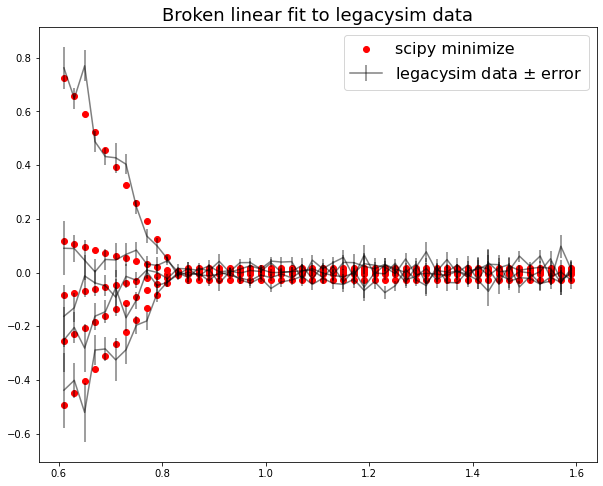

CPU times: user 7.36 s, sys: 326 ms, total: 7.68 s
Wall time: 7.7 s


In [4]:
%%time
# Here we look at the effect of using yerr when fitting 

fig = plt.figure(figsize=(10,8))

test = ELG_dndz(legacysim_data, data='legacysim')
#test = ELG_dndz(data, data='catalogue')
print(test.res.fun)
#test.get_chi2()
params = test.params
print(params)
dndz = test.predict_dndz((test.z_h, test.depth_h),*params)
plt.scatter(test.z_h, dndz, color='red', label='scipy minimize')

#test2 = ELG_dndz_old(legacysim_data, data='legacysim', fit='exponential')
#test2.get_chi2()
#params = test2.fit_dndz()[0]
#print(params)
#dndz_err = test2.predict_dndz_exp((test2.z_h, test2.depth_h),*params)
#plt.scatter(test2.z_h, dndz_err, color='b', label='scipy curve_fit')

bins=test.bins-1
kw= dict(color='k', alpha=0.5)
plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
for ite in range(10):
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.errorbar(test.z_h[i:j], test.dndz_h[i:j], yerr=test.yerr[i:j], **kw)
    #plt.plot(test.z_h[i:j], (test.dndz_h[i:j]+1)/(dndz_err+1), yerr=test.yerr[i:j], **kw)
plt.legend(fontsize=16)
plt.title('Broken linear fit to legacysim data', fontsize=18)
plt.show()
#print(test.pred_weights.min(), test.pred_weights.max())

In [5]:
wmin, wmax = 0.5, 2.0 # min and max weight
print(f'total: {test.new_weights.size}')
print(f'weight less than {wmin}: {test.new_weights[test.new_weights < wmin].size}')
print(f'{test.new_weights[test.new_weights < wmin].size/test.new_weights.size*100:.3f}%')
print(f'weight greater than {wmax}: {test.new_weights[test.new_weights > wmax].size}')
print(f'{test.new_weights[test.new_weights > wmax].size/test.new_weights.size*100:.3f}%')

total: 446953
weight less than 0.5: 748
0.167%
weight greater than 2.0: 31
0.007%


In [6]:
dmin, dmax = -1.0, 1.0 # min and max [dndz - 1]
print(f'total: {test.dndz_vals.size}')
print(f'[dndz - 1] less than {dmin}: {test.dndz_vals[test.dndz_vals < dmin].size}')
print(f'{test.dndz_vals[test.dndz_vals < dmin].size/test.dndz_vals.size*100:.3f}%')
print(f'[dndz - 1] greater than {dmax}: {test.dndz_vals[test.dndz_vals > dmax].size}')
print(f'{test.dndz_vals[test.dndz_vals > dmax].size/test.dndz_vals.size*100:.3f}%')

total: 446953
[dndz - 1] less than -1.0: 0
0.000%
[dndz - 1] greater than 1.0: 748
0.167%


In [7]:
test.new_weights.min()
np.unique(test.new_weights)

array([0.20630669, 0.22211747, 0.22458976, ..., 2.56185479, 2.57790481,
       2.59884008])

In [8]:
np.unique(np.log10(test.depth_h))

array([2.28115471, 2.45611025, 2.53705105, 2.62538729, 2.83720977])

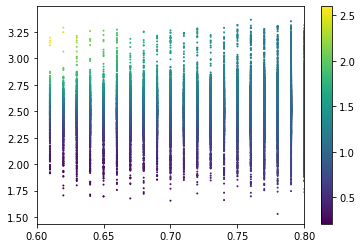

In [9]:
#fig = plt.figure(figsize=(10,8))
sc = plt.scatter(test.z,np.log10(test.depth),c=test.new_weights, s=1)
plt.xlim(0.6,0.8)
plt.colorbar(sc)
plt.show()

[ -0.77948942   0.94212811   0.83553054 -18.41448467  -0.66934513
   2.76041267 -15.32798643]
[1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2
 3.3 3.4]


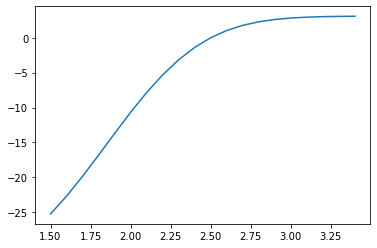

In [10]:
a,b,c,d,e,f,g = test.params
print(test.params)
depth = np.arange(1.5,3.5,0.1)
print(depth)
fun = (d*sp.erf(depth/e+f) + g) # (d*depth +  e*depth**2 + f) # (d*depth + e*depth**2 + f*depth**3 + g)
plt.plot(depth, fun)
plt.show()

[ -0.96598143   1.16700701   0.83591183 -17.85558477  22.99180028
  -4.62639882 -26.81988326]
[1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2
 3.3 3.4]


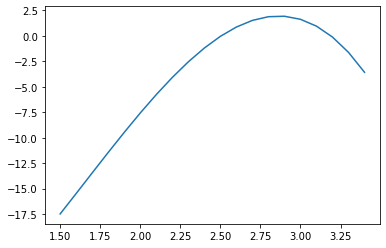

In [11]:
a,b,c,d,e,f,g = test.params
print(test.params)
depth = np.arange(1.5,3.5,0.1)
print(depth)
fun = (d*depth + e*depth**2 + f*depth**3 + g)
plt.plot(depth, fun)
plt.show()

-0.6152129530840917 3.847152474695214


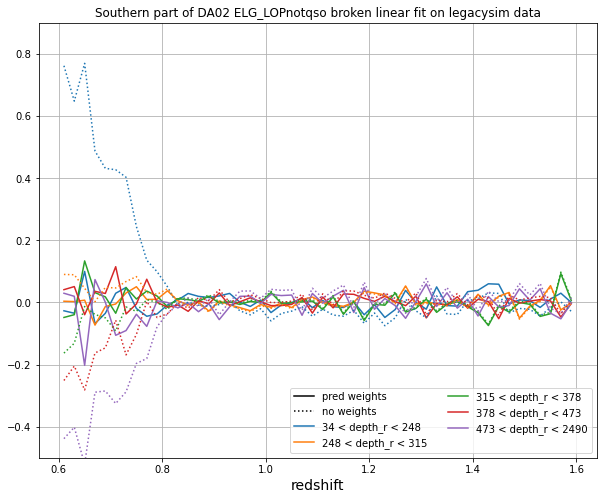

In [11]:
#test = ELG_dndz(data, data='catalogue', fit='exponential')
test = ELG_dndz(legacysim_data, data='legacysim', fit='exponential')
#test.get_chi2()
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
#fig = plt.gcf()
#fig.set_size_inches(7, 5)
ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso')+' broken linear fit on legacysim data')#, fontsize=18)

ax.plot([], [], linestyle='-', color='k', label='pred weights')
ax.plot([], [], linestyle=':', color='k', label='no weights')

test.plot_dndz_new_weights(ls='-', legend=True)
plt.xlabel('redshift', fontsize=14)
plt.ylim(-0.5,0.9)
test.plot_dndz_no_pred_weights(ls=':', )
ax.grid(True)
#plt.savefig(f'{plot_dir}/exponential_fit_on_legacysim_data.png', bbox_inches='tight', pad_inches=0.1, dpi=200)
plt.show()

######################################################
#test = ELG_dndz(legacysim_data, data='legacysim', fit='polynomial')
#test.get_chi2()
#fig = plt.figure(figsize=(10,8))
#ax = plt.gca()
#ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso')+' pol fit on legacysim data', fontsize=18)

#ax.plot([], [], linestyle='-', color='k', label='pred weights')
#ax.plot([], [], linestyle=':', color='k', label='no weights')

#test.plot_dndz_new_weights(ls='-', legend=True)
#plt.xlabel('redshift', fontsize=14)
#plt.ylim(-0.5,0.9)
#test.plot_dndz_no_pred_weights(ls=':', )
#plt.show()

In [56]:
#test = ELG_dndz(legacysim_data)
mask = test.new_weights<0
d_ = test.depth[mask]
z_ = test.z[mask]
print(mask.sum())
print(d_.min(), d_.max())
print(z_.min(), z_.max())
print()

print(f'best fit coeff {test.fit_dndz()[0]}')
dval = 1000
print(f'number of datapoints with depth greater than {dval} with negative weights: {d_[d_>dval].size}.')

5943
444.78662 2317.3699
0.0 0.82

best fit coeff [ 6.01088954e-05 -7.26085472e-05  8.36883088e-01 -1.28814402e+03
  2.43606300e+00 -1.57231420e-03  2.12725171e+05]
number of datapoints with depth greater than 1000 with negative weights: 1412.


In [5]:
test = ELG_dndz(legacysim_data)
zmask = test.z >0.8
zmask &= test.z < 0.9
print(test.f[zmask].min(),test.f[zmask].max())

-409.6264432272423 12.786675042142237
-6.77090692984934 5.932919360450333


In [7]:
test = ELG_dndz(legacysim_data)
zmask = test.z >0.8
zmask &= test.z < 1.0
w = test.new_weights#[zmask]
print(f'#negative weights: {w[w<0].size}\n#positive weights:{w[w>0].size}')
print(f'min: {w.min():4f}\nmax: {w.max():.4f}')
w[w<0]=1
print(f'min: {w.min():4f}\nmax: {w.max():.4f}')

-409.6264432272423 12.786675042142237
#negative weights: 5943
#positive weights:620320
min: -25691.936687
max: 190774.4410
min: 0.072534
max: 190774.4410


# Yerr in exponential fitting

-105.64938093802952 12.753478641760658
number of data points: 250
number of free parameters: 7
reduced $\chi^2$: 0.9353048414586147
[-2.16600601e-06  2.61681759e-06  8.36796734e-01  3.62076523e+04
 -7.02634046e+01  4.72246655e-02 -5.88801626e+06]


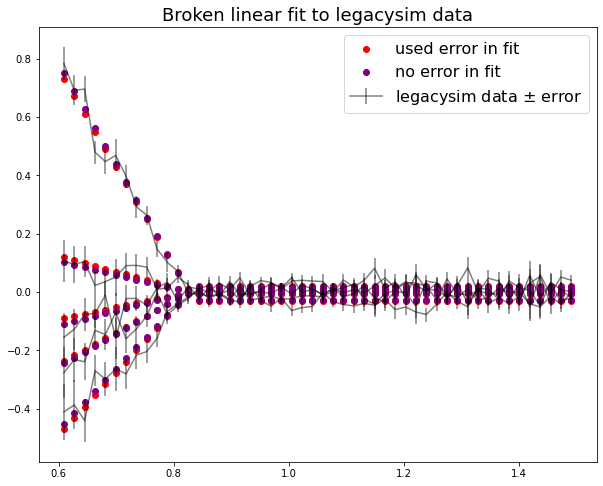

In [10]:
# Here we look at the effect of using yerr when fitting 

fig = plt.figure(figsize=(10,8))
test = ELG_dndz_old(legacysim_data, data='legacysim', fit='exponential')
test.get_chi2()
params = test.fit_dndz()[0]
print(params)
dndz_err = test.predict_dndz_exp((test.z_h, test.depth_h),*params)
plt.scatter(test.z_h, dndz_err, color='r', label='used error in fit')

params = test.fit_dndz(include_yerr=False)[0]
dndz = test.predict_dndz_exp((test.z_h, test.depth_h),*params)
plt.scatter(test.z_h, dndz, color='purple', label='no error in fit')

bins=test.bins-1
kw= dict(color='k', alpha=0.5)
plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
for ite in range(10):
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.errorbar(test.z_h[i:j], test.dndz_h[i:j], yerr=test.yerr[i:j], **kw)
    #plt.plot(test.z_h[i:j], (test.dndz_h[i:j]+1)/(dndz_err+1), yerr=test.yerr[i:j], **kw)
plt.legend(fontsize=16)
plt.title('Broken linear fit to legacysim data', fontsize=18)
plt.show()
#print(test.pred_weights.min(), test.pred_weights.max())

In [8]:
def predict_dndz_exp(X,d, e, f, g):
    depth = X
    return  (d*depth + e*depth**2 + f*depth**3 + g)


test = ELG_dndz(legacysim_data)
params = test.fit_dndz()[0]
a,b,c,d,e,f,g = params
print(params)
print(predict_dndz_exp((test.depth.min()),d, e, f, g), predict_dndz_exp((test.depth.max()),d, e, f, g))
print(predict_dndz_exp((np.median(test.depth)),d, e, f, g))

-409.6264432272423 12.786675042142237
[ 6.01088954e-05 -7.26085472e-05  8.36883088e-01 -1.28814402e+03
  2.43606300e+00 -1.57231420e-03  2.12725171e+05]
212725.17099229197 -12162019.941282865
-5481.869580766972


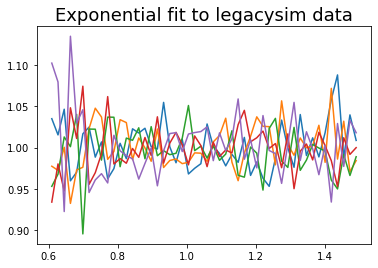

In [9]:
bins=test.bins-1
kw= dict(color='k', alpha=0.5)
#plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
for ite in range(5):
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.plot(test.z_h[i:j], (test.dndz_h[i:j]+1)/(dndz_err[i:j]+1))
#plt.legend(fontsize=16)
plt.title('Exponential fit to legacysim data', fontsize=18)
plt.show()

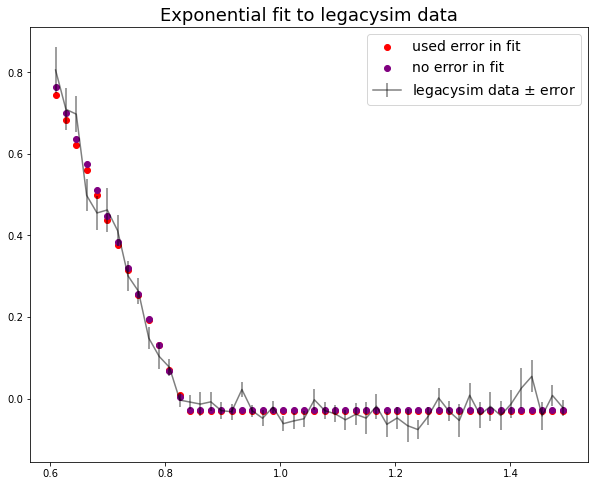

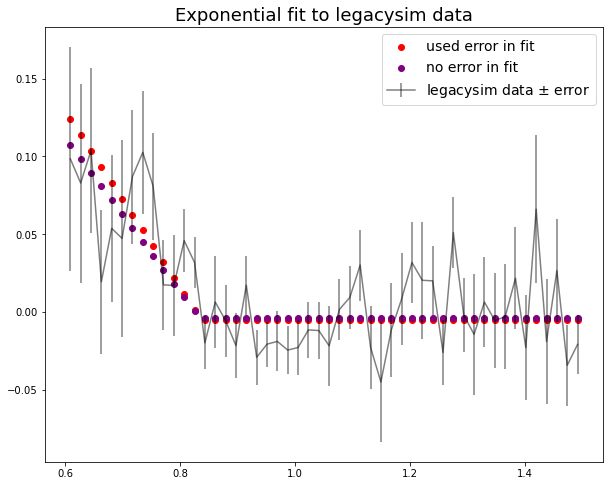

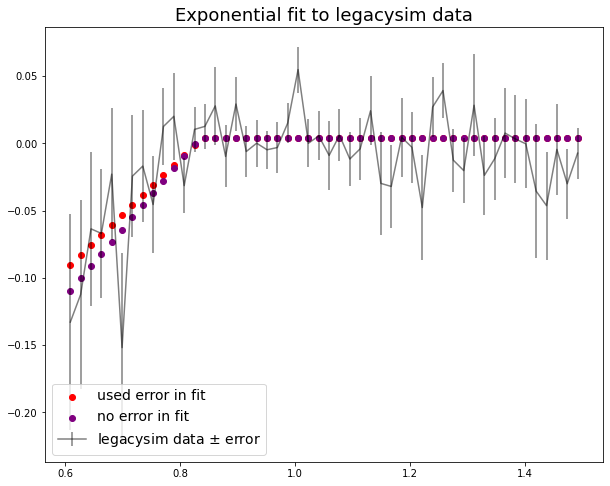

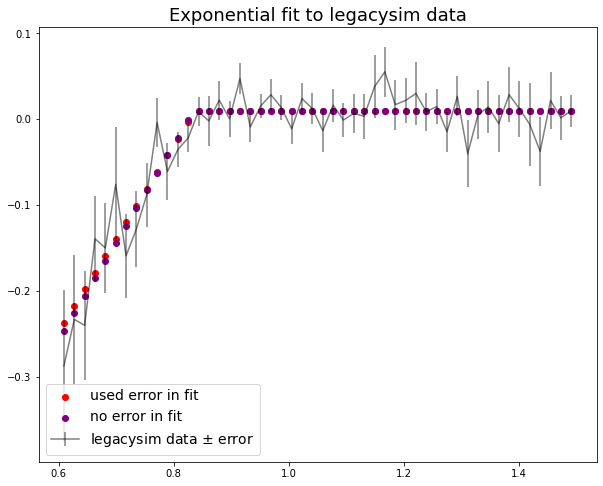

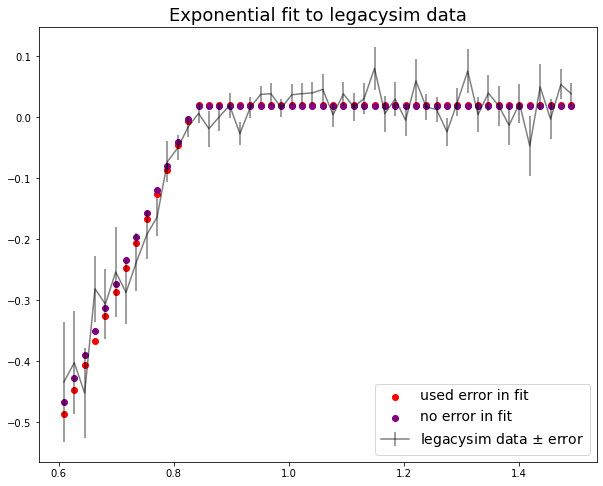

In [10]:
# Here we look at the effect of using yerr when fitting 
bins=test.bins-1
kw= dict(color='k', alpha=0.5)
for ite in range(5):
    fig = plt.figure(figsize=(10,8))
                     
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.errorbar(test.z_h[i:j], test.dndz_h[i:j], yerr=test.yerr[i:j], **kw)
    plt.scatter(test.z_h[i:j], dndz_err[i:j], color='r')
    plt.scatter(test.z_h[i:j], dndz[i:j], color='purple')

    plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
    plt.scatter([], [], color='r', label='used error in fit')
    plt.scatter([], [], color='purple', label='no error in fit')
    plt.legend(fontsize=14)
    plt.title('Exponential fit to legacysim data', fontsize=18)
    plt.show()
#print(test.pred_weights.min(), test.pred_weights.max())

# Yerr in polynomial fitting

-1095.4575 6119.9404


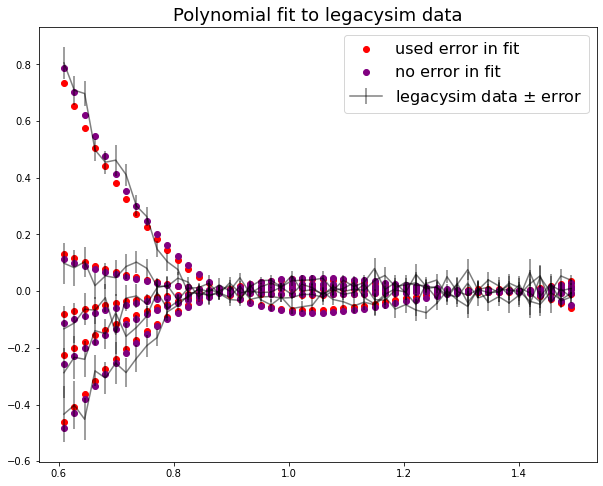

In [13]:
# Here we look at the effect of using yerr when fitting 

fig = plt.figure(figsize=(10,8))
test = ELG_dndz(legacysim_data, fit='polynomial')
params = test.fit_dndz()[0]
dndz_err = test.predict_dndz_pol((test.z_h, test.depth_h),*params)
plt.scatter(test.z_h, dndz_err, color='r', label='used error in fit')

params = test.fit_dndz(include_yerr=False)[0]
dndz = test.predict_dndz_pol((test.z_h, test.depth_h),*params)
plt.scatter(test.z_h, dndz, color='purple', label='no error in fit')

bins=50
kw= dict(color='k', alpha=0.5)
plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
for ite in range(5):
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.errorbar(test.z_h[i:j], test.dndz_h[i:j], yerr=test.yerr[i:j], **kw)
plt.title('Polynomial fit to legacysim data', fontsize=18)
plt.legend(fontsize=16)
#print(test.pred_weights.min(), test.pred_weights.max())

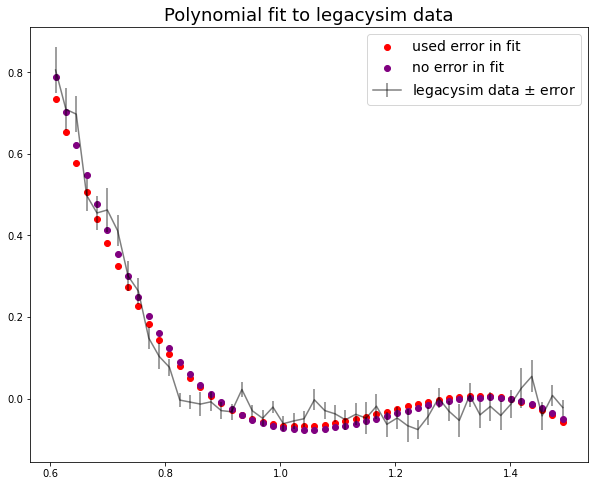

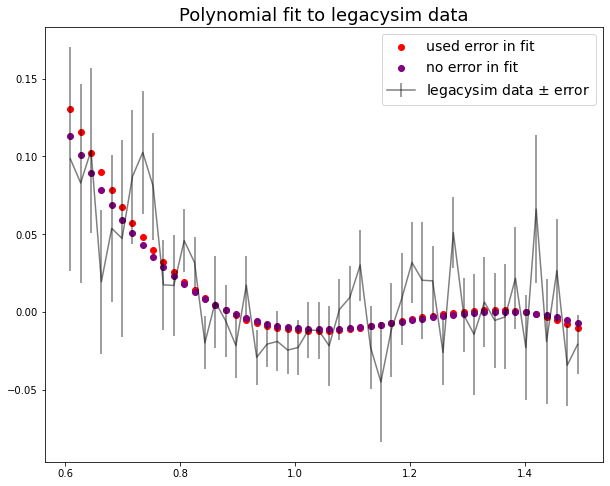

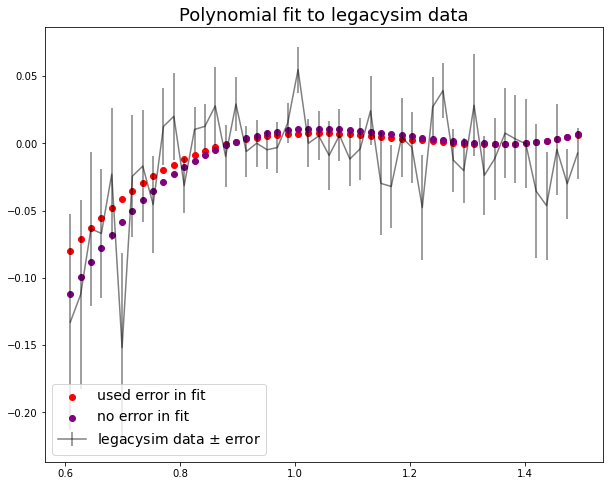

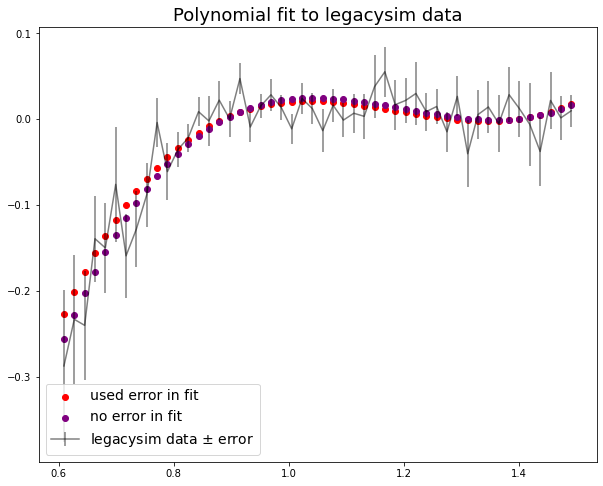

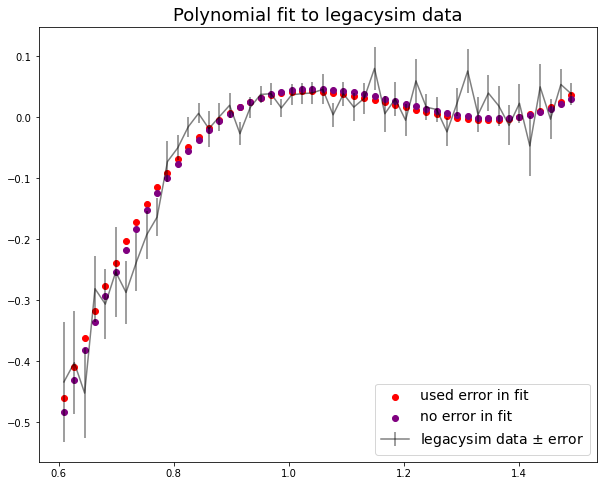

In [14]:
# Here we look at the effect of using yerr when fitting 
bins=50
kw= dict(color='k', alpha=0.5)
for ite in range(5):
    fig = plt.figure(figsize=(10,8))
                     
    i, j = (bins)*ite, (bins)*(ite+1)
    plt.errorbar(test.z_h[i:j], test.dndz_h[i:j], yerr=test.yerr[i:j], **kw)
    plt.scatter(test.z_h[i:j], dndz_err[i:j], color='r')
    plt.scatter(test.z_h[i:j], dndz[i:j], color='purple')

    plt.errorbar([],[],yerr=[], label=f'legacysim data $\pm$ error',**kw)
    plt.scatter([], [], color='r', label='used error in fit')
    plt.scatter([], [], color='purple', label='no error in fit')
    plt.legend(fontsize=14)
    plt.title('Polynomial fit to legacysim data', fontsize=18)
    plt.show()
#print(test.pred_weights.min(), test.pred_weights.max())

-518.8257640999336 19.563188800088025


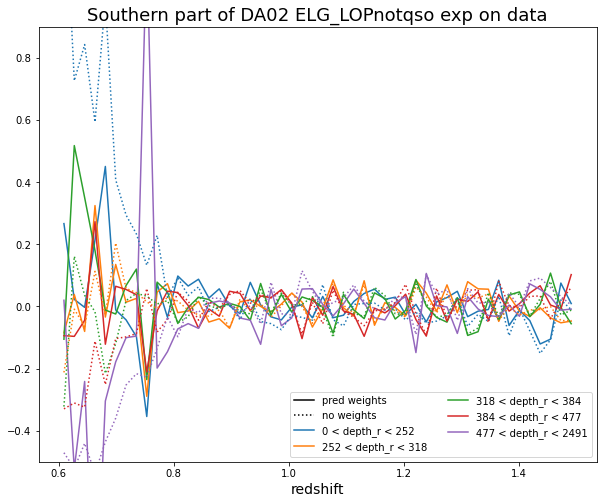

-1078.9300861235818 55.95683094315902


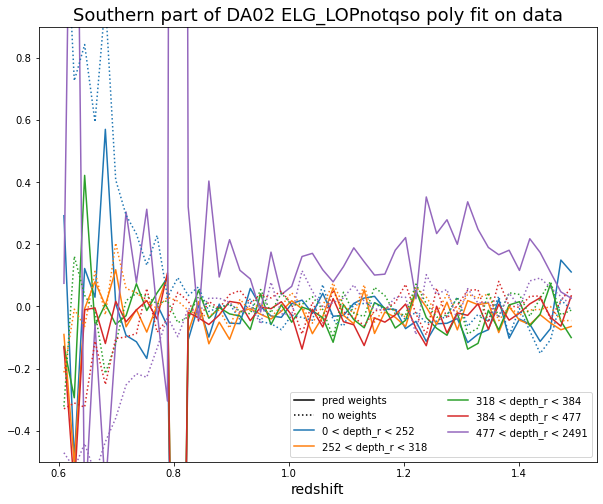

In [11]:
test = ELG_dndz(data, data='catalogue', fit='exponential')
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso')+' exp on data', fontsize=18)

ax.plot([], [], linestyle='-', color='k', label='pred weights')
ax.plot([], [], linestyle=':', color='k', label='no weights')

test.plot_dndz_new_weights(ls='-', legend=True)
plt.xlabel('redshift', fontsize=14)
plt.ylim(-0.5,0.9)
test.plot_dndz_no_pred_weights(ls=':', )
plt.show()

######################################################
test = ELG_dndz(data, data='catalogue', fit='polynomial')
fig = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.set_title('Southern part of DA02 {}'.format('ELG_LOPnotqso')+' poly fit on data', fontsize=18)

ax.plot([], [], linestyle='-', color='k', label='pred weights')
ax.plot([], [], linestyle=':', color='k', label='no weights')

test.plot_dndz_new_weights(ls='-', legend=True)
plt.xlabel('redshift', fontsize=14)
plt.ylim(-0.5,0.9)
test.plot_dndz_no_pred_weights(ls=':', )
plt.show()

# Functions

In [2]:
def plot_dndz_variations_test(ax, z, samples, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', labels=None):

    usamples = np.unique(samples)
    nsamples = len(usamples)
    if labels is None:
        labels = [None]*nsamples
    
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)*np.sqrt(nsamples)
    mid = (zbins[:-1] + zbins[1:])/2.
    ax.fill_between(mid, -perr, perr, color='gray')
    
    dndz_list = []
    
    for isample, (sample, label) in enumerate(zip(usamples, labels)):
        #print(isample,(sample,label), samples)
        mask = samples == sample
        #print(len(z[mask]))
        dndzw_sample = np.histogram(z[mask], bins=zbins, weights=weights[mask] if weights is not None else None)[0]
        ratio = dndzw_sample.sum()/dndzw.sum()
        toplot =  1./ratio*dndzw_sample/dndzw - 1.
        #print(toplot)
        dndz_list.append(toplot)
        ax.plot(mid,toplot, color='C{:d}'.format(isample), linestyle=linestyle, label=label)
    
    ax.set_xlabel('redshift')
    ax.set_ylabel('relative change in n(z)')
    ax.grid(True)
    ax.set_ylim(-0.3, 0.3)
    #print(dndz_list)
    return mid, dndz_list

In [3]:
def make_table(z, depth, dndz, depth_label=''):
    from astropy.table import Table, Column
    zl = np.concatenate([z for i in range(len(dndz))])
    dl = np.concatenate([np.full(dndz[i].size,depth[i]) for i in range(len(dndz))])
    dndzl = np.concatenate(dndz)
    t = Table([zl,dl,dndzl], names=('z',depth_label,'dndz') )
    return t

# plotting dndz

In [4]:
plot_dir = 'plots'

run = 'south'
region = run[0].upper()
base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'

test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
legacysim_data, h = ft.read(f'{test_dir}/legacysim_data_{run}.fits', header=True)
data = ft.read(f'{test_dir}/data_{run}.fits')

In [5]:
bins = 51

mean depth per bin (depth_r): [186.78526, 282.5174, 341.4434, 418.4132, 676.3567]
median depth per bin (depth_r): [199.1338, 284.7622, 340.27487, 416.2537, 561.1151]


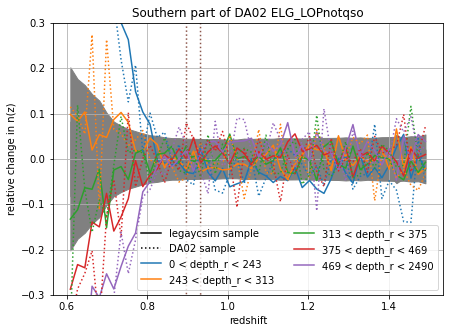

In [6]:
for prefix in ['ELG_LOPnotqso']:#,'ELG']:
    for column, name in [('GALDEPTH_R', 'depth_r')]:#, ('GALDEPTH_G', 'depth_g'), ('EBV', 'ebv')][:-1]:
        z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
        depth = legacysim_data[column]
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        #print(quantiles)
        labels = ['{:.0f} < {} < {:.0f}'.format(low, name, high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        #print(labels)
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        
        #
        d_mean_list = []
        d_median_list = []
        #print(min(depth), max(depth))
        usamples = np.unique(samples)
        nsamples = len(usamples)
        for sample in usamples[:nsamples-1]:
            mask = (sample == samples)
            #print(depth[mask].size)
            #print(min(depth[mask]), max(depth[mask]))
            depth_mean = depth[mask].mean()
            depth_median = np.median(depth[mask])
            d_mean_list.append(depth_mean)
            d_median_list.append(depth_median)
        print(f'mean depth per bin ({name}): {d_mean_list}')
        print(f'median depth per bin ({name}): {d_median_list}')
        #
        
        ax = plt.gca()
        fig = plt.gcf()
        fig.set_size_inches(7, 5)
        ax.plot([], [], linestyle='-', color='k', label='legaycsim sample')
        ax.plot([], [], linestyle=':', color='k', label='DA02 sample')
        mid, l = plot_dndz_variations_test(ax, z, samples, zbins=np.linspace(0.6, 1.5, bins), linestyle='-', labels=labels)

        #
        if name=='depth_r':
            t1 = make_table(mid,d_mean_list,l,depth_label=name)
            labels1 = labels
        elif name=='depth_g':
            t2 = make_table(mid,d_median_list,l,depth_label=name)
            labels2 = labels
        #
        
        data_full = data
        data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format(prefix)))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        data_clustering = data_clustering[ind1]
        z = data_clustering['Z']
        weights = data_clustering['WEIGHT_COMP']
        depth = data_full[column][ind2]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        _,_ = plot_dndz_variations_test(ax, z, samples, zbins=np.linspace(0.6, 1.5, bins), weights=weights, linestyle=':')
        ax.set_title('Southern part of DA02 {}'.format(prefix))

        ax.legend(loc=4, ncol=2)
        filename = os.path.join(plot_dir, 'dndz_{}_{}_{}.png'.format(prefix, run, name))
        #fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

# Fit redshift and depth at once
objective function will have $F(z)*G(depth)$
We look at 4 different models, 3 have polynomial form, while one has exponential form.

In [7]:
def objective1(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return (a*x1 + b*x1**2 + c) * (d*x2 + e*x2**2 + f*x2**3 + g)

In [8]:
def objective2(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return  (b * np.exp(-a*x1) + c) * (d*x2 + e*x2**2 + f*x2**3 + g)

In [9]:
def objective3(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return (a*x1 + b*x1**2 + c*x1**3 + d) * (e*x2 + f*x2**2 + g)

In [10]:
def objective4(X, a, b, c, d, e, f, g, h):
    x1, x2 = X
    return (a*x1 + b*x1**2 + c*x1**3 + d) * (e*x2 + f*x2**2 + g*x2**3 + h)

In [11]:
# choose legacysim data to use for fitting
name = 'depth_r' 
if name=='depth_r':
    t = t1
    labels = labels1
elif name=='depth_g':
    t = t2
    labels = labels2

In [12]:
# choose the input and output variables
x1, x2, y = t['z'], t[f'{name}'], t['dndz']

In [13]:
# curve fit
popt_list = []
popt, _ = curve_fit(objective1, (x1,x2), y)
popt_list.append(popt)
popt, _ = curve_fit(objective2, (x1,x2), y)
popt_list.append(popt)
popt, _ = curve_fit(objective3, (x1,x2), y)
popt_list.append(popt)
popt, _ = curve_fit(objective4, (x1,x2), y)
popt_list.append(popt)

In [14]:
# summarize the parameter values
#a,b,c,d,e,f = popt
for i in range(4):
    print(popt_list[i])
#print(f'y = ({a:.5f} * x_1 + {b:.5f} * [x_1]^2 + {c:.5f}) * ({d:.5f} * x_2 + {e:.5f})')

[-9.03654460e-01  3.83860821e-01  5.12842631e-01 -1.74577466e-01
  3.36665611e-04 -2.19375724e-07  2.82554420e+01]
[ 8.75193234e+00 -4.94650157e-03  1.23323735e-06  1.12685940e+03
 -2.17488183e+00  1.41572106e-03 -1.82042405e+05]
[-6.22101714e+00  5.26843478e+00 -1.46159885e+00  2.39350374e+00
 -4.26927907e-02  3.68714940e-05  9.94414664e+00]
[ 3.43593842e-01 -2.90910152e-01  8.06836389e-02 -1.32221856e-01
  1.81982688e+00 -3.49946661e-03  2.27289310e-06 -2.95010960e+02]


In [15]:
#define a sequence of inputs between the smallest and largest known inputs
z_line = np.linspace(0.6, 1.5, bins)
depth_line = np.full_like(z_line, x2[0])

In [16]:
results = []
y_line = objective1((z_line,depth_line), *popt_list[0])
results.append(y_line)
y_line = objective2((z_line,depth_line), *popt_list[1])
results.append(y_line)
y_line = objective3((z_line,depth_line), *popt_list[2])
results.append(y_line)
y_line = objective4((z_line,depth_line), *popt_list[3])
results.append(y_line)

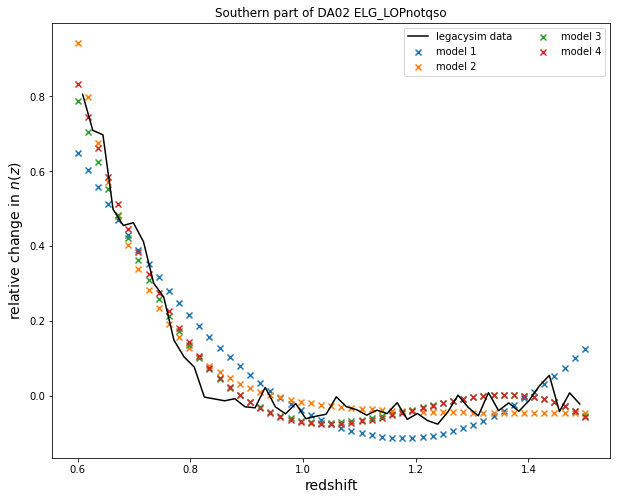

In [17]:
fig = plt.figure(figsize=(10,8))
plt.plot(x1[:(bins-1)], y[(bins-1)*0:(bins-1)*1], color='k', label='legacysim data')
for i in range(4):
    plt.scatter(z_line, results[i], marker='x', label=f'model {i+1}')

#plt.ylim(-0.3,0.3)
plt.title('Southern part of DA02 {}'.format(prefix))
#plt.ylabel('models mult. by some coeff', fontsize=14)
plt.ylabel(r'relative change in $n(z)$', fontsize=14)
plt.xlabel(r'redshift',fontsize=14)
plt.legend(loc=1, ncol=2)
plt.show()

From the tests done above, we can see that the `objective4` gives the best model for the moment.

$$
F(z)*G(\gamma) = (az + bz^2 + cz^3 + d) \cdot (e\gamma + f\gamma^2 + g\gamma^3 + h)
$$

where $\gamma$ is depth.

In [18]:
y_line = objective4((x1,x2), *popt_list[3])

In [19]:
y.size

250

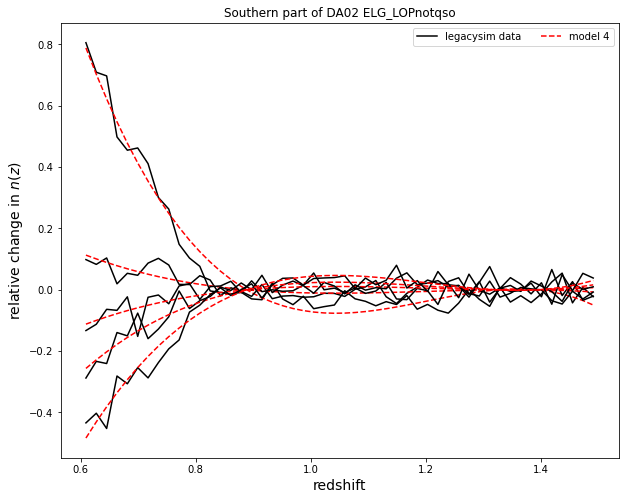

In [20]:
fig = plt.figure(figsize=(10,8))
plt.plot([],[], color='k', label='legacysim data')
plt.plot([],[], color='r', ls='--', label=f'model {4}')

for i in range(5):
    plt.plot(x1[:bins-1], y[(bins-1)*i:(bins-1)*(i+1)], color='k')
    plt.plot(x1[:bins-1], y_line[(bins-1)*i:(bins-1)*(i+1)], color='r', ls='--')
    
plt.title('Southern part of DA02 {}'.format(prefix))
plt.ylabel(r'relative change in $n(z)$', fontsize=14)
plt.xlabel(r'redshift',fontsize=14)
plt.legend(loc=1, ncol=2)
plt.show()

In [ ]:
def calc_xi2():
    

In [28]:
def objective2(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return  (b * np.exp(-a*x1) + c) * (d*x2 + e*x2**2 + f*x2**3 + g)

Model 2 (exponential fit):
number of bins: 250
number of free parameters: 7
reduced chi2: 0.0011963235849521562

Model 4 (polynomial fit):
number of bins: 250
number of free parameters: 8
reduced chi2: 0.0009770518852008359


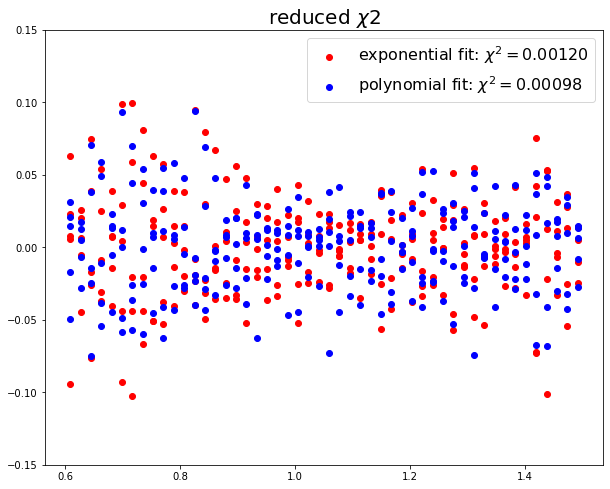

In [33]:

fig = plt.figure(figsize=(10,8))

print('Model 2 (exponential fit):')
res = curve_fit(objective2, (x1,x2), y, full_output=True)
#s_sq = ((test[2]['fvec']/yerr)**2).sum()
N, n = len(res[2]['fvec']), len(res[0])
print(f'number of bins: {N}')
print(f'number of free parameters: {n}')
s_sq = (res[2]['fvec']**2).sum() / (N-n)
print(f'reduced chi2: {s_sq}')
#plt.plot(x1,objective2((x1,x2), *test[0]))
plt.scatter(x1,res[2]['fvec'], color='r', label=f'exponential fit: $\chi^2 = {s_sq:.5f}$')

print('')
print('Model 4 (polynomial fit):')
res2 = curve_fit(objective4, (x1,x2), y, full_output=True)
#s_sq2 = ((test2[2]['fvec']/yerr)**2).sum()
N2, n2 = len(res2[2]['fvec']), len(res2[0])
print(f'number of bins: {N2}')
print(f'number of free parameters: {n2}')
s_sq2 = ((res2[2]['fvec'])**2).sum() / (N2-n2)
print(f'reduced chi2: {s_sq2}')
plt.scatter(x1,res2[2]['fvec'], color='b', label=f'polynomial fit: $\chi^2 = {s_sq2:.5f}$')

plt.title('reduced $\chi2$', fontsize=20)
plt.legend(fontsize=16)
plt.ylim(-0.15, 0.15)
plt.show()

In [22]:
# here we are trying out model 2 seems to fit only one depth bin at a time
fig = plt.figure(figsize=(10,8))

# choose the input and output variables
x1, x2, y = t['z'], t[f'{name}'], t['dndz']

#define a sequence of inputs between the smallest and largest known inputs
z_line = np.linspace(0.6, 1.5, bins)
depth_line = np.full_like(z_line, x2[0])

i, j = (bins-1)*0, (bins-1)*1

#popt, _ = curve_fit(objective2, (x1[i:j],x2[i:j]), y[i:j])

print(popt)

#y_line = objective2((x1[i:j],x2[i:j]), *popt)
y_line = objective2((x1,x2), *popt)

#plt.plot(x1[i:j],y[i:j])
plt.plot(x1,y)
#plt.scatter(x1[i:j], y_line, marker='x', color='r')
plt.scatter(x1, y_line, marker='x', color='r')
plt.scatter(x1, y_line, marker='x', color='r')
#plt.ylim(-.8,.8)

[ 3.43593842e-01 -2.90910152e-01  8.06836389e-02 -1.32221856e-01
  1.81982688e+00 -3.49946661e-03  2.27289310e-06 -2.95010960e+02]


TypeError: objective2() takes 7 positional arguments but 9 were given

<Figure size 720x576 with 0 Axes>

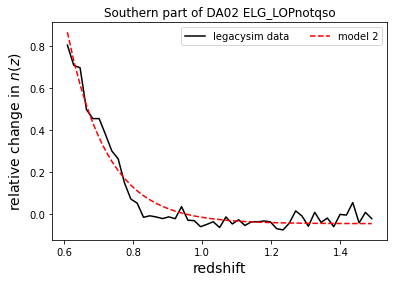

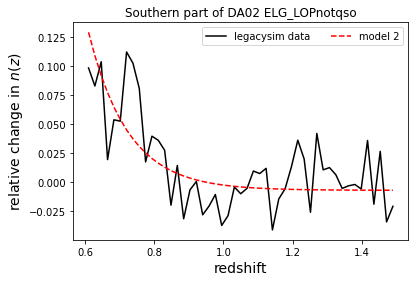

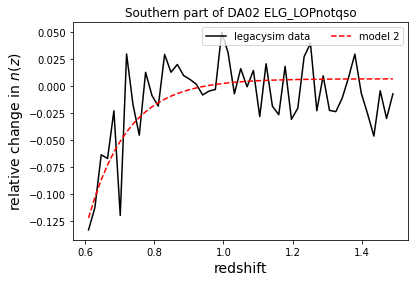

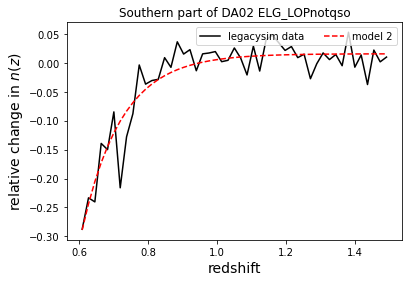

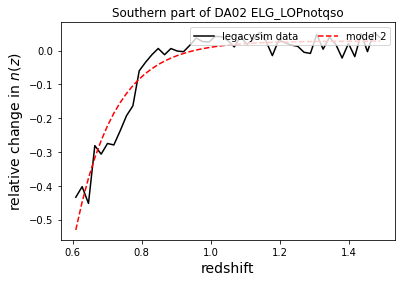

In [23]:
for i in range(5):
    #fig = plt.figure(figsize=(10,8))
    plt.plot([],[], color='k', label='legacysim data')
    plt.plot([],[], color='r', ls='--', label=f'model {2}')
    
    plt.plot(x1[:bins-1], y[(bins-1)*i:(bins-1)*(i+1)], color='k')
    plt.plot(x1[:bins-1], y_line[(bins-1)*i:(bins-1)*(i+1)], color='r', ls='--')
    
    plt.title('Southern part of DA02 {}'.format(prefix))
    plt.ylabel(r'relative change in $n(z)$', fontsize=14)
    plt.xlabel(r'redshift',fontsize=14)
    plt.legend(loc=1, ncol=2)
    plt.show()

In [20]:
x1_line = np.concatenate([np.linspace(min(x1),max(x1),num=49) for i in range(5)])
y_line = objective2((x1_line,x2), *popt_list[3])

TypeError: objective2() takes 8 positional arguments but 9 were given

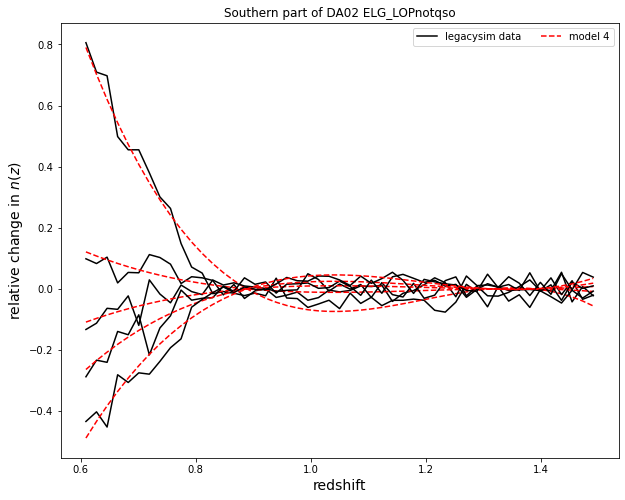

In [32]:
fig = plt.figure(figsize=(10,8))
plt.plot([],[], color='k', label='legacysim data')
plt.plot([],[], color='r', ls='--', label=f'model {4}')

for i in range(5):
    plt.plot(x1[:bins-1], y[(bins-1)*i:(bins-1)*(i+1)], color='k')
    plt.plot(x1_line[:bins-1], y_line[(bins-1)*i:(bins-1)*(i+1)], color='r', ls='--')
    
plt.title('Southern part of DA02 {}'.format(prefix))
plt.ylabel(r'relative change in $n(z)$', fontsize=14)
plt.xlabel(r'redshift',fontsize=14)
plt.legend(loc=1, ncol=2)
plt.show()

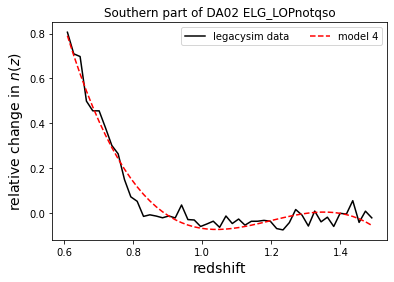

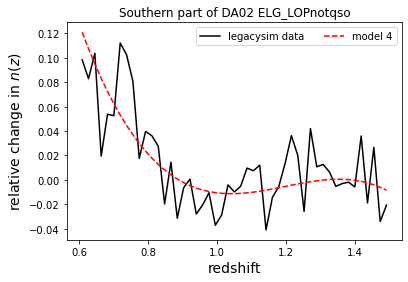

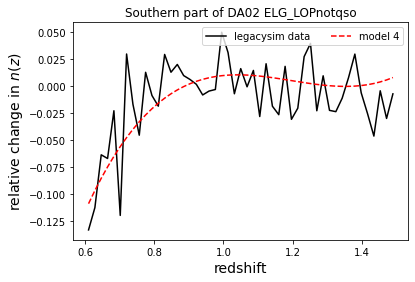

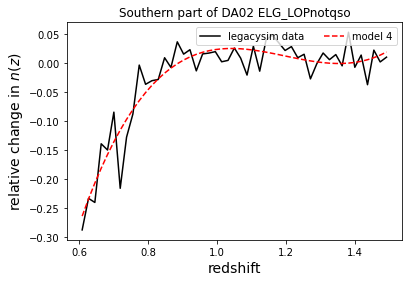

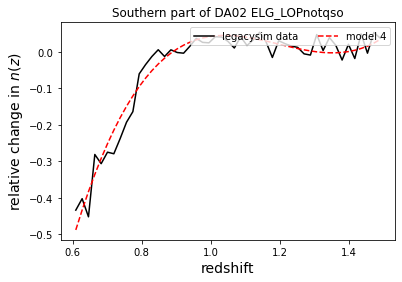

In [20]:
for i in range(5):
    #fig = plt.figure(figsize=(10,8))
    plt.plot([],[], color='k', label='legacysim data')
    plt.plot([],[], color='r', ls='--', label=f'model {4}')
    
    plt.plot(x1[:bins-1], y[(bins-1)*i:(bins-1)*(i+1)], color='k')
    plt.plot(x1_line[:bins-1], y_line[(bins-1)*i:(bins-1)*(i+1)], color='r', ls='--')
    
    plt.title('Southern part of DA02 {}'.format(prefix))
    plt.ylabel(r'relative change in $n(z)$', fontsize=14)
    plt.xlabel(r'redshift',fontsize=14)
    plt.legend(loc=1, ncol=2)
    plt.show()

# Implement model 4 for predicting dndz

In [2]:
def objective2(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return  (b * np.exp(-a*x1) + c) * (d*x2 + e*x2**2 + f*x2**3 + g)

In [3]:
def objective4(X, a, b, c, d, e, f, g, h):
    x1, x2 = X
    return (a*x1 + b*x1**2 + c*x1**3 + d) * (e*x2 + f*x2**2 + g*x2**3 + h)

In [4]:
def plot_dndz_variations_test4(ax, z, depth, samples, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', labels=None):

    usamples = np.unique(samples)
    nsamples = len(usamples)
    if labels is None:
        labels = [None]*nsamples
    
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)*np.sqrt(nsamples)
    mid = (zbins[:-1] + zbins[1:])/2.
    ax.fill_between(mid, -perr, perr, color='gray')
    
    z_list = []
    depth_list = []
    dndz_list = []
    pred_list = []
    perr_list = []
    yerr_list = []
    xerr_list = []

    for isample, (sample, label) in enumerate(zip(usamples, labels)):
        mask = samples == sample
        depth_sample = np.full_like(mid, depth[mask].mean())
        dndzw_sample = np.histogram(z[mask], bins=zbins, weights=weights[mask] if weights is not None else None)[0]
        ratio = dndzw_sample.sum()/dndzw.sum()
        toplot =  1./ratio*dndzw_sample/dndzw - 1.
        
        if isample < 5:
            # implement model 4 for fit
            popt, _ = curve_fit(objective4, (mid,depth_sample), toplot)
            pred = objective4((mid,depth_sample), *popt)
            #
            z_list.append(mid)
            depth_list.append(depth_sample)
            dndz_list.append(toplot)
            pred_list.append(pred)
            yerr = 1 / np.sqrt(dndzw_sample) # np.sqrt(toplot) 
            yerr_list.append(yerr)
            
            ax.plot(mid,toplot, color='C{:d}'.format(isample), linestyle=linestyle, label=label)
      
    #z_list = [mid for i in range(5)]
    z = np.concatenate(z_list)
    depth = np.concatenate(depth_list)
    dndz = np.concatenate(dndz_list)
    pred = np.concatenate(pred_list)
    yerr = np.concatenate(yerr_list)
    
    
    ax.set_xlabel('redshift')
    ax.set_ylabel('relative change in n(z)')
    ax.grid(True)
    ax.set_ylim(-0.3, 0.3)
    #ax.set_ylim(1-0.3, 1.3)
    #print(dndz_list)
    return z, depth, dndz, pred, yerr

In [5]:
plot_dir = 'plots'

run = 'south'
region = run[0].upper()
base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'

test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
legacysim_data, h = ft.read(f'{test_dir}/legacysim_data_{run}.fits', header=True)
data = ft.read(f'{test_dir}/data_{run}.fits')

bins =51

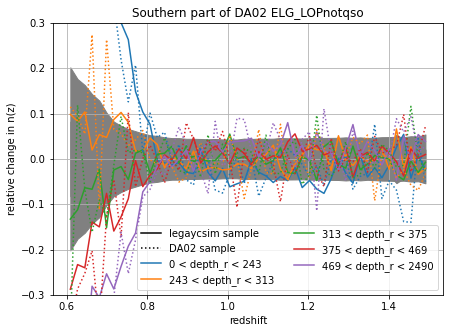

In [7]:
for prefix in ['ELG_LOPnotqso']:#,'ELG']:
    for column, name in [('GALDEPTH_R', 'depth_r')]:#, ('GALDEPTH_G', 'depth_g'), ('EBV', 'ebv')][:-1]:
        z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
        depth = legacysim_data[column]
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        #print(quantiles)
        labels = ['{:.0f} < {} < {:.0f}'.format(low, name, high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        #print(labels)
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        
        ax = plt.gca()
        fig = plt.gcf()
        fig.set_size_inches(7, 5)
        ax.plot([], [], linestyle='-', color='k', label='legaycsim sample')
        ax.plot([], [], linestyle=':', color='k', label='DA02 sample')
        z_binned1, depth_binned1, dndz_binned1, pred_binned1, yerr1 = plot_dndz_variations_test4(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), linestyle='-', labels=labels)
        
        # implement model 4 for fit
        #popt, _ = curve_fit(objective4, (z_binned,depth_binned), dndz_binned)
        #pred1 = objective4((z_binned, depth_binned), *popt)
        #
        
        data_full = data
        data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format(prefix)))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        data_clustering = data_clustering[ind1]
        z = data_clustering['Z']
        weights = data_clustering['WEIGHT_COMP']
        depth = data_full[column][ind2]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        z_binned2, depth_binned2, dndz_binned2, pred_binned2, yerr2 = plot_dndz_variations_test4(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), weights=weights, linestyle=':')
        
        # implement model 4 for fit
        #popt, _ = curve_fit(objective4, (z_binned,depth_binned), dndz_binned)
        #pred2 = objective4((z_binned, depth_binned), *popt)
        #
        
        ax.set_title('Southern part of DA02 {}'.format(prefix))

        ax.legend(loc=4, ncol=2)
        filename = os.path.join(plot_dir, 'dndz_{}_{}_{}.png'.format(prefix, run, name))
        #fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

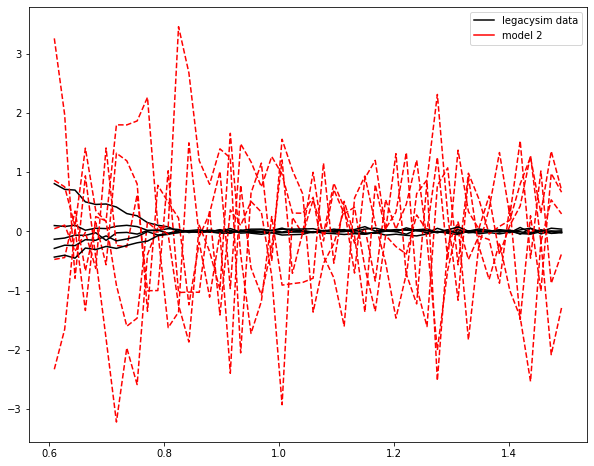

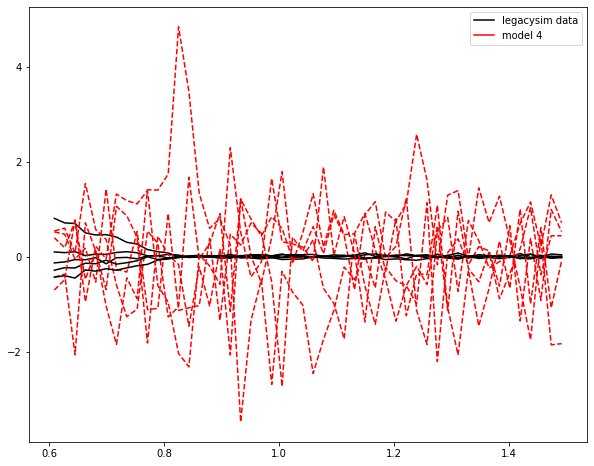

In [11]:
# choose the input and output variables (Legacysim_data)
x1, x2, y = z_binned1, depth_binned1, dndz_binned1
res1 = curve_fit(objective2, (x1,x2), y, sigma=yerr1, full_output=True)
res2 = curve_fit(objective4, (x1,x2), y, sigma=yerr1, full_output=True)
res = dict()
res['model_2'] = res1
res['model_4'] = res2

for model_i in [2, 4]:
    fig = plt.figure(figsize=(10,8))

    plt.plot([],[],color='k',ls='-',label='legacysim data')
    plt.plot([],[],color='r',label=f'model {model_i}')
    for ite in range(5):
        i, j = (bins-1)*ite, (bins-1)*(ite+1)

        plt.plot(z_binned1[:(bins-1)], dndz_binned1[i:j], ls='-', color='k')

        pred_dndz = res[f'model_{model_i}'][2]['fvec'][i:j] + dndz_binned1[i:j]
        plt.plot(z_binned1[:(bins-1)], pred_dndz, ls='--', color='r')
        
    plt.legend()
    plt.show()

Model 2 (exponential fit):
number of bins: 250
number of free parameters: 7
reduced chi2: 0.0011963235849521562

Model 4 (polynomial fit):
number of bins: 250
number of free parameters: 8
reduced chi2: 0.0009770518852008359


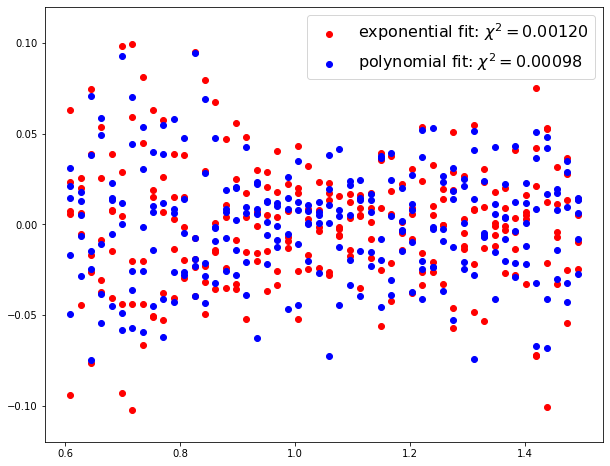

In [8]:
fig = plt.figure(figsize=(10,8))

print('Model 2 (exponential fit):')
N, n = len(res1[2]['fvec']), len(res1[0])
print(f'number of bins: {N}')
print(f'number of free parameters: {n}')
s_sq = (res1[2]['fvec']**2).sum() / (N-n)
#s_sq = ((res1[2]['fvec'] / yerr1)**2).sum() / (N-n)
print(f'reduced chi2: {s_sq}')
#plt.plot(x1,objective2((x1,x2), *test[0]))
plt.scatter(x1,res1[2]['fvec'], color='r', label=f'exponential fit: $\chi^2 = {s_sq:.5f}$')

print('')
print('Model 4 (polynomial fit):')
N2, n2 = len(res2[2]['fvec']), len(res2[0])
print(f'number of bins: {N2}')
print(f'number of free parameters: {n2}')
s_sq2 = ((res2[2]['fvec'])**2).sum() / (N2-n2)
#s_sq2 = ((res2[2]['fvec'] / yerr1)**2).sum() / (N2-n2)
print(f'reduced chi2: {s_sq2}')
plt.scatter(x1,res2[2]['fvec'], color='b', label=f'polynomial fit: $\chi^2 = {s_sq2:.5f}$')

plt.title(f'', fontsize=20)
plt.legend(fontsize=16)
plt.ylim(-0.12, 0.12)
plt.show()

Looking at the figure below, fitting using optimal values obtained from legacysim data seem to give better dndz predictions. 

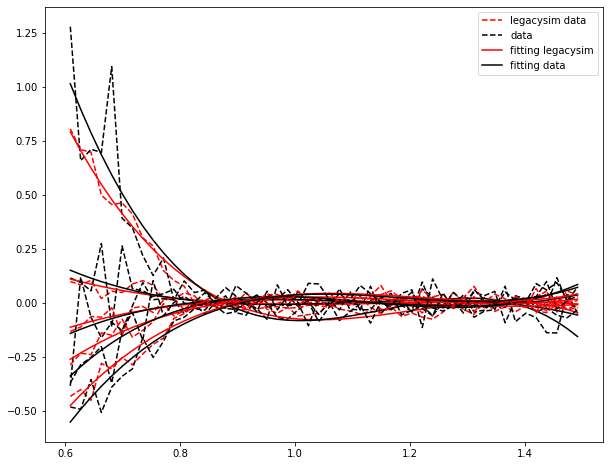

In [19]:
fig = plt.figure(figsize=(10,8))

plt.plot([],[],color='r',ls='--',label='legacysim data')
plt.plot([],[],color='k',ls='--',label='data')

plt.plot([],[],color='r',label='fitting legacysim')
plt.plot([],[],color='k',label='fitting data')
for i in range(5):
    plt.plot(z_binned[:(bins-1)], dndz_binned1[(bins-1)*i:(bins-1)*(i+1)], ls='--', color='r')
    plt.plot(z_binned[:(bins-1)], dndz_binned2[(bins-1)*i:(bins-1)*(i+1)], ls='--', color='k')
    
    plt.plot(z_binned[:(bins-1)], pred_binned1[(bins-1)*i:(bins-1)*(i+1)], color='r')
    plt.plot(z_binned[:(bins-1)], pred_binned2[(bins-1)*i:(bins-1)*(i+1)], color='k')
plt.legend()

# Implement model 2 for predicting dndz

In [2]:
def objective2(X, a, b, c, d, e, f, g):
    x1, x2 = X
    return  (b * np.exp(-a*x1) + c) * (d*x2 + e*x2**2 + f*x2**3 + g)

In [3]:
def plot_dndz_variations_test2(ax, z, depth, samples, weights=None, zbins=np.linspace(0.6, 1.5, 18), linestyle='-', labels=None):

    usamples = np.unique(samples)
    nsamples = len(usamples)
    if labels is None:
        labels = [None]*nsamples
    
    dndzw = np.histogram(z, bins=zbins, weights=weights)[0]
    dndz = np.histogram(z, bins=zbins)[0]
    perr = 1./np.sqrt(dndz)*np.sqrt(nsamples)
    mid = (zbins[:-1] + zbins[1:])/2.
    ax.fill_between(mid, -perr, perr, color='gray')
    
    z_list = []
    depth_list = []
    dndz_list = []
    pred_list = []
    perr_list = []
    yerr_list = []
    xerr_list = []

    for isample, (sample, label) in enumerate(zip(usamples, labels)):
        mask = samples == sample
        depth_sample = np.full_like(mid, depth[mask].mean())
        dndzw_sample = np.histogram(z[mask], bins=zbins, weights=weights[mask] if weights is not None else None)[0]
        ratio = dndzw_sample.sum()/dndzw.sum()
        toplot =  1./ratio*dndzw_sample/dndzw - 1.
        
        if isample < 5:
            # implement model 4 for fit
            #popt, _ = curve_fit(objective2, (mid,depth_sample), toplot)
            #pred = objective2((mid,depth_sample), *popt)
            #
            z_list.append(mid)
            depth_list.append(depth_sample)
            dndz_list.append(toplot)
            #pred_list.append(pred)
            yerr = 1 / np.sqrt(dndzw_sample) # np.sqrt(toplot) 
            yerr_list.append(yerr)
            
            ax.plot(mid,toplot, color='C{:d}'.format(isample), linestyle=linestyle, label=label)
      
    #z_list = [mid for i in range(5)]
    z = np.concatenate(z_list)
    depth = np.concatenate(depth_list)
    dndz = np.concatenate(dndz_list)
    pred =[] #np.concatenate(pred_list)
    yerr = np.concatenate(yerr_list)
    
    
    ax.set_xlabel('redshift')
    ax.set_ylabel('relative change in n(z)')
    ax.grid(True)
    ax.set_ylim(-0.3, 0.3)
    #ax.set_ylim(1-0.3, 1.3)
    #print(dndz_list)
    return z, depth, dndz, pred, yerr

In [4]:
plot_dir = 'plots'

run = 'south'
region = run[0].upper()
base_dir = '/global/cfs/cdirs/desi/survey/catalogs/DA02/LSS/guadalupe/LSScats/2/'

test_dir = '/global/cscratch1/sd/arosado/legacysim_fitting'
legacysim_data, h = ft.read(f'{test_dir}/legacysim_data_{run}.fits', header=True)
data = ft.read(f'{test_dir}/data_{run}.fits')

bins =51

[   0.          243.14416504  312.57003784  375.06185913  469.41705322
 2489.85449219]
[ 8.75193234e+00 -4.94650157e-03  1.23323735e-06  1.12685940e+03
 -2.17488183e+00  1.41572106e-03 -1.82042405e+05]


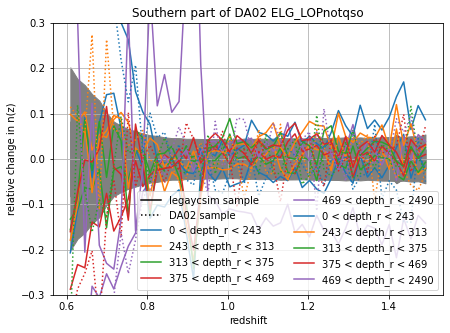

In [5]:
for prefix in ['ELG_LOPnotqso']:#,'ELG']:
    for column, name in [('GALDEPTH_R', 'depth_r')]:#, ('GALDEPTH_G', 'depth_g'), ('EBV', 'ebv')][:-1]:
        z = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
        depth = legacysim_data[column]
        quantiles = np.quantile(depth, q=np.linspace(0., 1., 6))
        print(quantiles)
        #print(quantiles)
        labels = ['{:.0f} < {} < {:.0f}'.format(low, name, high) for low, high in zip(quantiles[:-1], quantiles[1:])]
        #print(labels)
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        
        ax = plt.gca()
        fig = plt.gcf()
        fig.set_size_inches(7, 5)
        ax.plot([], [], linestyle='-', color='k', label='legaycsim sample')
        ax.plot([], [], linestyle=':', color='k', label='DA02 sample')
        z_binned1, depth_binned1, dndz_binned1, pred_binned1, yerr1 = plot_dndz_variations_test2(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), linestyle='-', labels=labels)
        
        #ax.set_title('Southern part of DA02 {}'.format(prefix))
        #ax.legend(loc=4, ncol=2)
        #plt.show()
        
        # implement model 2 for fit
        popt, _ = curve_fit(objective2, (z_binned1,depth_binned1), dndz_binned1)
        print(popt)
        pred = objective2((z, depth), *popt)
        pred_weight = 1/abs(pred+1)
        z_binned1w, depth_binned1w, dndz_binned1w, pred_binned1w, yerr1w = plot_dndz_variations_test2(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), linestyle='-', weights=pred_weight, labels=labels)
        #
        
        data_full = data
        data_clustering = Catalogue.load(os.path.join(base_dir, '{}zdone_clustering.dat.fits'.format(prefix)))
        ind1, ind2 = utils.overlap(data_clustering['TARGETID'], data_full['TARGETID'])
        data_clustering = data_clustering[ind1]
        z = data_clustering['Z']
        weights = data_clustering['WEIGHT_COMP']
        depth = data_full[column][ind2]
        samples = np.clip(np.digitize(depth, quantiles) - 1, 0, len(quantiles) - 1)
        z_binned2, depth_binned2, dndz_binned2, pred_binned2, yerr2 = plot_dndz_variations_test2(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), weights=weights, linestyle=':')
        #z_binned3, depth_binned3, dndz_binned3, pred_binned3, yerr3 = plot_dndz_variations_test2(ax, z, depth, samples, zbins=np.linspace(0.6, 1.5, bins), weights=None, linestyle=':')
        
        # implement model 2 for fit
        #popt, _ = curve_fit(objective2, (z_binned2,depth_binned2), dndz_binned2)
        #print(popt)
        #pred_binned2 = objective2((z_binned2, depth_binned2), *popt)
        #
        
        ax.set_title('Southern part of DA02 {}'.format(prefix))

        ax.legend(loc=4, ncol=2)
        filename = os.path.join(plot_dir, 'dndz_{}_{}_{}.png'.format(prefix, run, name))
        #fig.savefig(filename, bbox_inches='tight', pad_inches=0.1, dpi=200)
        plt.show()

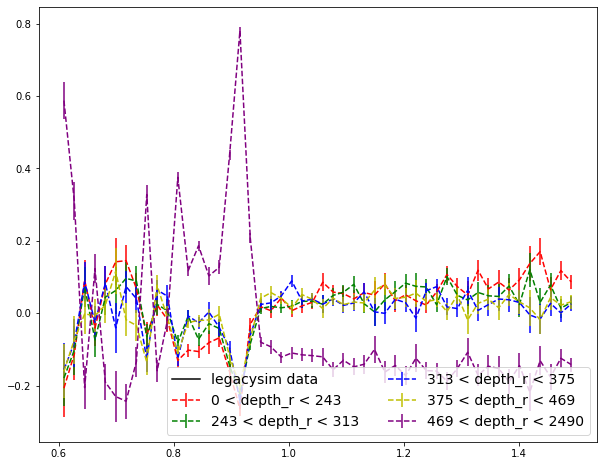

In [7]:
fig = plt.figure(figsize=(10,8))

plt.plot([],[],color='k',ls='-',label='legacysim data')

colors = ['r','g','b','y','purple']
for ite in range(5):
    i, j = (bins-1)*ite, (bins-1)*(ite+1)
    plt.errorbar(z_binned1w[:(bins-1)], dndz_binned1w[i:j], yerr=yerr1w[i:j], color=colors[ite], ls='--', label=labels[ite])
    #plt.errorbar(z_binned1[:(bins-1)], dndz_binned1[i:j], yerr=yerr1[i:j], color=colors[ite], ls='-', label=labels[ite])
plt.legend(loc=4,ncol=2, fontsize=14)
#plt.ylim(-0.3,0.3)
plt.show()

In [6]:
pred = objective2((z_binned1, depth_binned1), *popt)
print((1/pred).min(), (1/pred).max())
plt.scatter(z_binned1, dndz_binned1)
plt.title(r'$dndz$')
plt.ylim(-0.5,0.5)
plt.show()

plt.scatter(z_binned1, pred)
plt.title(r'$pred$')
plt.ylim(-0.5,0.5)
plt.show()

p = dndz_binned1-pred
plt.title(r'$dndz-pred$')
plt.scatter(z_binned1, p)
plt.ylim(-0.5,0.5)
plt.show()

p = dndz_binned1/pred
plt.title(r'$dndz/pred$')
plt.scatter(z_binned1, p)
plt.ylim(-0.5,0.5)
plt.show()

NameError: name 'popt' is not defined

In [14]:
pred_ = abs(pred)
pred_.min(), pred_.max()

(3.3754564e-09, 30462.875)

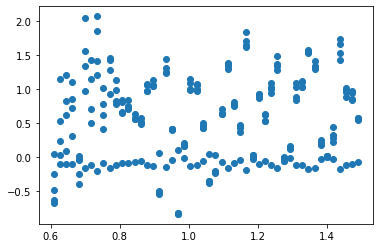

In [8]:
plt.scatter(z_binned1w, dndz_binned1w)

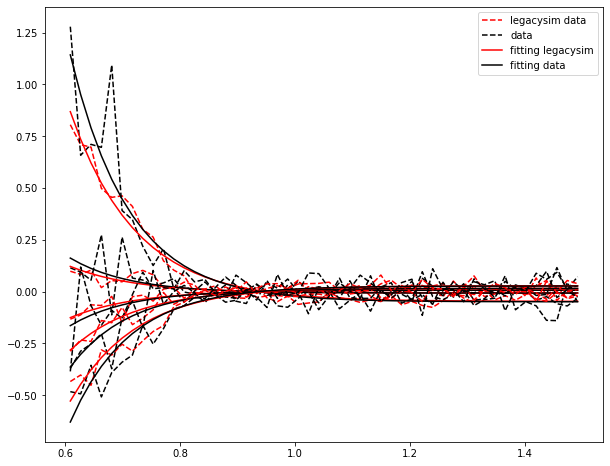

In [14]:
fig = plt.figure(figsize=(10,8))

plt.plot([],[],color='r',ls='--',label='legacysim data')
plt.plot([],[],color='k',ls='--',label='data')

plt.plot([],[],color='r',label='fitting legacysim')
plt.plot([],[],color='k',label='fitting data')
for i in range(5):
    plt.plot(z_binned1[:(bins-1)], dndz_binned1[(bins-1)*i:(bins-1)*(i+1)], ls='--', color='r')
    plt.plot(z_binned1[:(bins-1)], dndz_binned2[(bins-1)*i:(bins-1)*(i+1)], ls='--', color='k')
    
    plt.plot(z_binned1[:(bins-1)], pred_binned1[(bins-1)*i:(bins-1)*(i+1)], color='r')
    plt.plot(z_binned1[:(bins-1)], pred_binned2[(bins-1)*i:(bins-1)*(i+1)], color='k')
plt.legend()

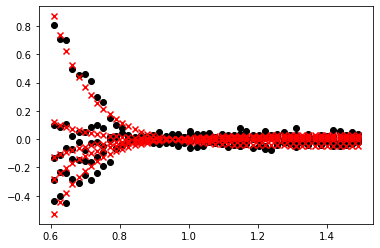

In [17]:
# choose the input and output variables (Legacysim_data)
x1, x2, y = z_binned1, depth_binned1, dndz_binned1
res = curve_fit(objective2, (x1,x2), y, full_output=True)

plt.scatter(x1,y, color='k')
plt.scatter(x1, res[2]['fvec']+y, color='r', marker='x')

In [20]:
x1 = legacysim_data['INPUT_HSC_MIZUKI_PHOTOZ_BEST']
x2 = legacysim_data['GALDEPTH_R']
pred = objective2((x1,x2), *res[0])

ValueError: operands could not be broadcast together with shapes (250,) (626263,) 